In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
#from metpy.io import get_test_data

import sys, os
import requests

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [2]:

ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nosip/caipeex_2mom_nosip/NWP_*.nc');
ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/control/caipeex_2mom_sip/NWP_*.nc');
ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nohm/caipeex_2mom_nohm/NWP_*.nc');
ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/norf/caipeex_2mom_norf/NWP_*.nc');
ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nobr/caipeex_2mom_nobr/NWP_*.nc');
ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nosb/caipeex_2mom_nosb/NWP_*.nc');


In [3]:

grid_caipeex = xr.open_dataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/control/caipeex_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_caipeex.clon)
clat_deg = np.degrees(grid_caipeex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([75.5, 17.5])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.3
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


73.96231325070727
78.03733091737507
15.966592379850837
20.032768784756854
75.0
76.0
17.8
17.2


(None, None)

In [4]:

window_cell = (
    (grid_caipeex.clat >= np.deg2rad(bottom_bound))
    & (grid_caipeex.clat <= np.deg2rad(top_bound))
    & (grid_caipeex.clon >= np.deg2rad(left_bound))
    & (grid_caipeex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_caipeex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_caipeex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_caipeex = reindex_grid(grid_caipeex, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)


window_vertex_indices :: [ 3670  3702  3718 ... 32701 32702 32703]
window_edge_indices :: [11072 11073 11074 ... 95287 95288 95289]


In [5]:

datasets = [ds_nosip, ds_4sip, ds_norf, ds_nohm, ds_nobr, ds_nosb]

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
ds_norf['tempc'] = ds_norf.temp-273.16;
ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
ds_nohm['tempc'] = ds_nohm.temp-273.16;
ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
ds_nobr['tempc'] = ds_nobr.temp-273.16;
ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
ds_nosb['tempc'] = ds_nosb.temp-273.16;
ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl


ht_4avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_4avg = ds_4sip.tempc.mean(dim=('time','ncells'))


In [6]:

aircraft_starttime='2019-09-30T07:00:00.000000000'
aircraft_endtime='2019-09-30T11:00:00.000000000'

ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_4sip_new = ds_4sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_norf_new = ds_norf.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nohm_new = ds_nohm.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nobr_new = ds_nobr.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosb_new = ds_nosb.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [7]:
# To print the following message:
# 1. write your message after ## (e.g., ## your_message)
# 2. press 'Esc'
# 3. pres 'm' --> your typed cell is markdown now
# 4. shift+enter or run the cell --> there you go !!!

# Latent heating rate


In [8]:

mean_ht_nosip = 1.e-3*ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = 1.e-3*ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = 1.e-3*ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = 1.e-3*ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = 1.e-3*ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# Latent heating rate with No SIP
filt_lhr = xr.where((ds_nosip.tq > 1.e-6) & (ds_nosip.w_vel > w_thres), ds_nosip.d_lhr, np.nan)
lhr_kpers_nosip = (1./1800.) * np.gradient(ds_nosip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosip = lhr_kpers_nosip * 86400.
mean_lhr_kperd_nosip = np.mean(lhr_kperd_nosip, axis=(0,2))

# Latent heating rate with 4-SIP
filt_lhr = xr.where((ds_4sip.tq > 1.e-6) & (ds_4sip.w_vel > w_thres), ds_4sip.d_lhr, np.nan)
lhr_kpers_4sip = (1./1800.) * np.gradient(ds_4sip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_4sip = lhr_kpers_4sip * 86400.
mean_lhr_kperd_4sip = np.mean(lhr_kperd_4sip, axis=(0,2))

# Latent heating rate with No Raindrop Shattering (RF)
filt_lhr = xr.where((ds_norf.tq > 1.e-6) & (ds_norf.w_vel > w_thres), ds_norf.d_lhr, np.nan)
lhr_kpers_norf = (1./1800.) * np.gradient(ds_norf.d_lhr, axis=0) # w.r.t. time
lhr_kperd_norf = lhr_kpers_norf * 86400.
mean_lhr_kperd_norf = np.mean(lhr_kperd_norf, axis=(0,2))

# Latent heating rate with No Hallett-Mossop (HM)
filt_lhr = xr.where((ds_nohm.tq > 1.e-6) & (ds_nohm.w_vel > w_thres), ds_nohm.d_lhr, np.nan)
lhr_kpers_nohm = (1./1800.) * np.gradient(ds_nohm.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nohm = lhr_kpers_nohm * 86400.
mean_lhr_kperd_nohm = np.mean(lhr_kperd_nohm, axis=(0,2))

# Latent heating rate with No ice-ice collision breakup (BR)
filt_lhr = xr.where((ds_nobr.tq > 1.e-6) & (ds_nobr.w_vel > w_thres), ds_nobr.d_lhr, np.nan)
lhr_kpers_nobr = (1./1800.) * np.gradient(ds_nobr.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nobr = lhr_kpers_nobr * 86400.
mean_lhr_kperd_nobr = np.mean(lhr_kperd_nobr, axis=(0,2))

# Latent heating rate with No Sublimation (SB)
filt_lhr = xr.where((ds_nosb.tq > 1.e-6) & (ds_nosb.w_vel > w_thres), ds_nosb.d_lhr, np.nan)
lhr_kpers_nosb = (1./1800.) * np.gradient(ds_nosb.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosb = lhr_kpers_nosb * 86400.
mean_lhr_kperd_nosb = np.mean(lhr_kperd_nosb, axis=(0,2))

# Change in lhr w.r.t. control
del_lhr_kperd_norf = mean_lhr_kperd_4sip-mean_lhr_kperd_norf
del_lhr_kperd_nohm = mean_lhr_kperd_4sip-mean_lhr_kperd_nohm
del_lhr_kperd_nobr = mean_lhr_kperd_4sip-mean_lhr_kperd_nobr
del_lhr_kperd_nosb = mean_lhr_kperd_4sip-mean_lhr_kperd_nosb
del_lhr_kperd_nosip = mean_lhr_kperd_4sip-mean_lhr_kperd_nosip


In [ ]:
# xarrays takes longer time to plot, convert them to numpy instead

variables = [mean_lhr_kperd_nosip, mean_lhr_kperd_4sip, mean_lhr_kperd_norf, mean_lhr_kperd_nohm, 
             mean_lhr_kperd_nobr, mean_lhr_kperd_nosb]
numpy_variables = [var.values for var in variables]

mean_lhr_kperd_nosip = numpy_variables[0]
mean_lhr_kperd_4sip = numpy_variables[1]
mean_lhr_kperd_norf = numpy_variables[2]
mean_lhr_kperd_nohm = numpy_variables[3]
mean_lhr_kperd_nobr = numpy_variables[4]
mean_lhr_kperd_nosb = numpy_variables[5]


In [14]:

del_lhr_kperd_norf = mean_lhr_kperd_norf-mean_lhr_kperd_4sip
del_lhr_kperd_nohm = mean_lhr_kperd_nohm-mean_lhr_kperd_4sip
del_lhr_kperd_nobr = mean_lhr_kperd_nobr-mean_lhr_kperd_4sip
del_lhr_kperd_nosb = mean_lhr_kperd_nosb-mean_lhr_kperd_4sip
del_lhr_kperd_nosip = mean_lhr_kperd_nosip-mean_lhr_kperd_4sip

per_del_lhr_kperd_norf = 100*(del_lhr_kperd_norf)/mean_lhr_kperd_4sip
per_del_lhr_kperd_nohm = 100*(del_lhr_kperd_nohm)/mean_lhr_kperd_4sip
per_del_lhr_kperd_nobr = 100*(del_lhr_kperd_nobr)/mean_lhr_kperd_4sip
per_del_lhr_kperd_nosb = 100*(del_lhr_kperd_nosb)/mean_lhr_kperd_4sip
per_del_lhr_kperd_nosip = 100*(del_lhr_kperd_nosip)/mean_lhr_kperd_4sip


In [12]:
variables = [mean_tempc_nosip, mean_tempc_4sip, mean_tempc_norf, mean_tempc_nohm, mean_tempc_nobr, mean_tempc_nosb]
numpy_variables = [var.values for var in variables]

mean_tempc_nosip = numpy_variables[0]
mean_tempc_4sip = numpy_variables[1]
mean_tempc_norf = numpy_variables[2]
mean_tempc_nohm = numpy_variables[3]
mean_tempc_nobr = numpy_variables[4]
mean_tempc_nosb = numpy_variables[5]

variables = [mean_ht_nosip, mean_ht_4sip, mean_ht_norf, mean_ht_nohm, mean_ht_nobr, mean_ht_nosb]
numpy_variables = [var.values for var in variables]

mean_ht_nosip = numpy_variables[0]
mean_ht_4sip = numpy_variables[1]
mean_ht_norf = numpy_variables[2]
mean_ht_nohm = numpy_variables[3]
mean_ht_nobr = numpy_variables[4]
mean_ht_nosb = numpy_variables[5]

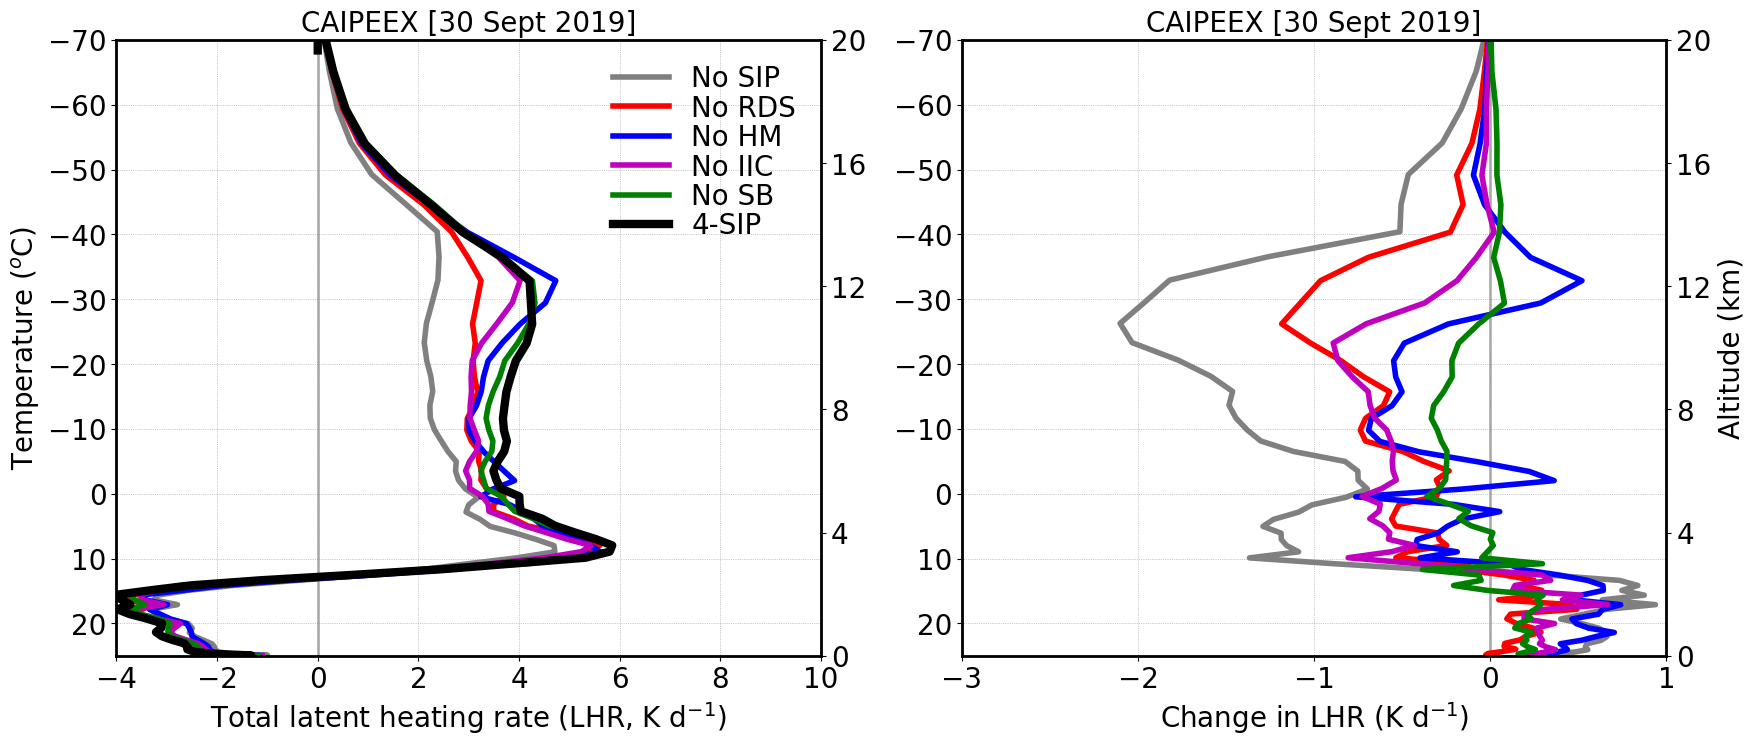

In [15]:

fontsize=20;
lnwdth=4;
alpha=0.8;

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt2.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.set_xlim(-4., 10)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-4, -2, 0, 2, 4, 6, 8, 10])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')

plt1.set_xlabel('Total latent heating rate (LHR, K d$^{-1}$)', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
#plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_visible(False)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(del_lhr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(del_lhr_kperd_nosb, mean_tempc_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(-3., 1)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-3, -2, -1, 0, 1])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

#plt1.legend()
#plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')

plt1.set_xlabel('Change in LHR (K d$^{-1}$)', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.show()


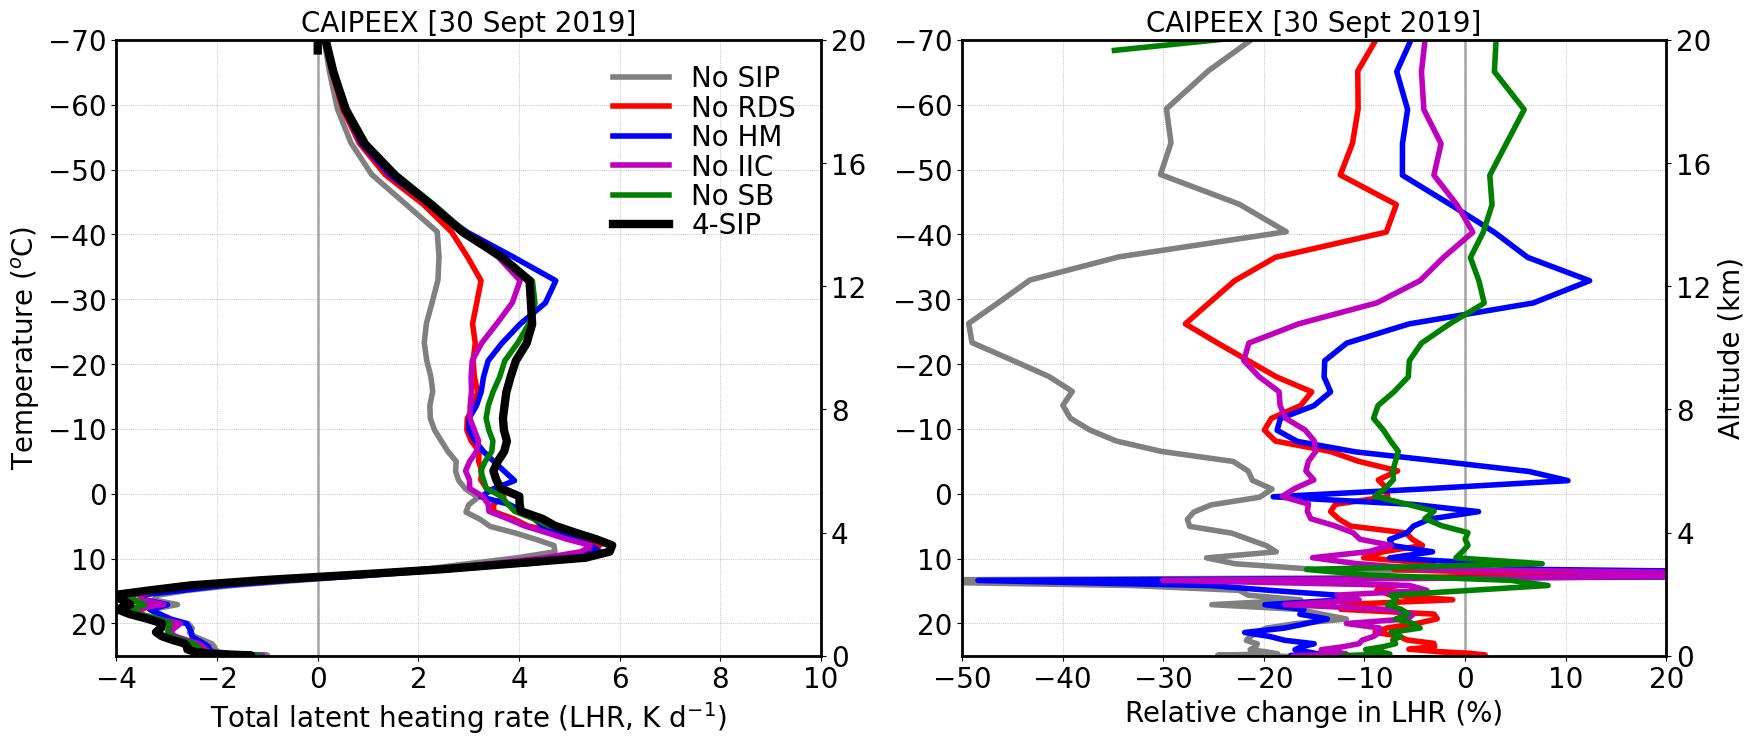

In [111]:

fontsize=20;
lnwdth=4;
alpha=0.8;

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt2.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.set_xlim(-4., 10)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-4, -2, 0, 2, 4, 6, 8, 10])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')

plt1.set_xlabel('Total latent heating rate (LHR, K d$^{-1}$)', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
#plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_visible(False)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(per_del_lhr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(per_del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(per_del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(per_del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(per_del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(per_del_lhr_kperd_nosb, mean_tempc_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(-50., 20)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

#plt1.set_xticks([-3, -2, -1, 0, 1])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

#plt1.legend()
#plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')

plt1.set_xlabel('Relative change in LHR (%)', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.show()


## TOA Radiative Fluxes

#### Calculating CRE
##### SW CRE = (Qcld_sw_dn - Qcld_sw_up) - (Qclear_sw_dn - Qclear_sw_up)
##### LW CRE = (Qcld_lw_dn - Qcld_lw_up) - (Qclear_lw_dn - Qclear_lw_up)
##### Net CRE = SW_CRE + LW_CRE

In [16]:

#### No SIP 
toa_sw_up_nosip = ds_nosip.swflx_up.isel(height_2=0).mean('ncells') #ds_nosip.swflx_up[:,0,:]
toa_sw_up_clr_nosip = ds_nosip.swflx_up_clr.isel(height_2=0).mean('ncells') #ds_nosip.swflx_up_clr[:,0,:]
toa_lw_up_nosip = ds_nosip.lwflx_up.isel(height_2=0).mean('ncells') #ds_nosip.lwflx_up[:,0,:]
toa_lw_up_clr_nosip = ds_nosip.lwflx_up_clr.isel(height_2=0).mean('ncells') #ds_nosip.lwflx_up_clr[:,0,:]

toa_sw_dn_nosip = ds_nosip.swflx_dn.isel(height_2=0).mean('ncells') #ds_nosip.swflx_dn[:,0,:]
toa_sw_dn_clr_nosip = ds_nosip.swflx_dn_clr.isel(height_2=0).mean('ncells') #ds_nosip.swflx_dn_clr[:,0,:]
toa_lw_dn_nosip = ds_nosip.lwflx_dn.isel(height_2=0).mean('ncells') #ds_nosip.lwflx_dn[:,0,:]
toa_lw_dn_clr_nosip = ds_nosip.lwflx_dn_clr.isel(height_2=0).mean('ncells') #ds_nosip.lwflx_dn_clr[:,0,:]

toa_sw_cre_nosip = (toa_sw_dn_nosip-toa_sw_up_nosip) - (toa_sw_dn_clr_nosip-toa_sw_up_clr_nosip)
toa_lw_cre_nosip = (toa_sw_dn_nosip-toa_lw_up_nosip) - (toa_sw_dn_clr_nosip-toa_lw_up_clr_nosip)
toa_net_cre_nosip = toa_sw_cre_nosip+toa_lw_cre_nosip

#### SIP 
toa_sw_up_4sip = ds_4sip.swflx_up.isel(height_2=0).mean('ncells') 
toa_sw_up_clr_4sip = ds_4sip.swflx_up_clr.isel(height_2=0).mean('ncells') 
toa_lw_up_4sip = ds_4sip.lwflx_up.isel(height_2=0).mean('ncells') 
toa_lw_up_clr_4sip = ds_4sip.lwflx_up_clr.isel(height_2=0).mean('ncells') 

toa_sw_dn_4sip = ds_4sip.swflx_dn.isel(height_2=0).mean('ncells') 
toa_sw_dn_clr_4sip = ds_4sip.swflx_dn_clr.isel(height_2=0).mean('ncells') 
toa_lw_dn_4sip = ds_4sip.lwflx_dn.isel(height_2=0).mean('ncells') 
toa_lw_dn_clr_4sip = ds_4sip.lwflx_dn_clr.isel(height_2=0).mean('ncells') 

toa_sw_cre_4sip = (toa_sw_dn_4sip-toa_sw_up_4sip) - (toa_sw_dn_clr_4sip-toa_sw_up_clr_4sip)
toa_lw_cre_4sip = (toa_sw_dn_4sip-toa_lw_up_4sip) - (toa_sw_dn_clr_4sip-toa_lw_up_clr_4sip)
toa_net_cre_4sip = toa_sw_cre_4sip+toa_lw_cre_4sip

#### No RF 
toa_sw_up_norf = ds_norf.swflx_up.isel(height_2=0).mean('ncells') 
toa_sw_up_clr_norf = ds_norf.swflx_up_clr.isel(height_2=0).mean('ncells') 
toa_lw_up_norf = ds_norf.lwflx_up.isel(height_2=0).mean('ncells') 
toa_lw_up_clr_norf = ds_norf.lwflx_up_clr.isel(height_2=0).mean('ncells') 

toa_sw_dn_norf = ds_norf.swflx_dn.isel(height_2=0).mean('ncells') 
toa_sw_dn_clr_norf = ds_norf.swflx_dn_clr.isel(height_2=0).mean('ncells') 
toa_lw_dn_norf = ds_norf.lwflx_dn.isel(height_2=0).mean('ncells') 
toa_lw_dn_clr_norf = ds_norf.lwflx_dn_clr.isel(height_2=0).mean('ncells')

toa_sw_cre_norf = (toa_sw_dn_norf-toa_sw_up_norf) - (toa_sw_dn_clr_norf-toa_sw_up_clr_norf)
toa_lw_cre_norf = (toa_sw_dn_norf-toa_lw_up_norf) - (toa_sw_dn_clr_norf-toa_lw_up_clr_norf)
toa_net_cre_norf = toa_sw_cre_norf+toa_lw_cre_norf

#### No HM 
toa_sw_up_nohm = ds_nohm.swflx_up.isel(height_2=0).mean('ncells') 
toa_sw_up_clr_nohm = ds_nohm.swflx_up_clr.isel(height_2=0).mean('ncells') 
toa_lw_up_nohm = ds_nohm.lwflx_up.isel(height_2=0).mean('ncells') 
toa_lw_up_clr_nohm = ds_nohm.lwflx_up_clr.isel(height_2=0).mean('ncells') 

toa_sw_dn_nohm = ds_nohm.swflx_dn.isel(height_2=0).mean('ncells') 
toa_sw_dn_clr_nohm = ds_nohm.swflx_dn_clr.isel(height_2=0).mean('ncells') 
toa_lw_dn_nohm = ds_nohm.lwflx_dn.isel(height_2=0).mean('ncells') 
toa_lw_dn_clr_nohm = ds_nohm.lwflx_dn_clr.isel(height_2=0).mean('ncells')

toa_sw_cre_nohm = (toa_sw_dn_nohm-toa_sw_up_nohm) - (toa_sw_dn_clr_nohm-toa_sw_up_clr_nohm)
toa_lw_cre_nohm = (toa_sw_dn_nohm-toa_lw_up_nohm) - (toa_sw_dn_clr_nohm-toa_lw_up_clr_nohm)
toa_net_cre_nohm = toa_sw_cre_nohm+toa_lw_cre_nohm

#### No IIC 
toa_sw_up_nobr = ds_nobr.swflx_up.isel(height_2=0).mean('ncells') 
toa_sw_up_clr_nobr = ds_nobr.swflx_up_clr.isel(height_2=0).mean('ncells') 
toa_lw_up_nobr = ds_nobr.lwflx_up.isel(height_2=0).mean('ncells') 
toa_lw_up_clr_nobr = ds_nobr.lwflx_up_clr.isel(height_2=0).mean('ncells') 

toa_sw_dn_nobr = ds_nobr.swflx_dn.isel(height_2=0).mean('ncells') 
toa_sw_dn_clr_nobr = ds_nobr.swflx_dn_clr.isel(height_2=0).mean('ncells') 
toa_lw_dn_nobr = ds_nobr.lwflx_dn.isel(height_2=0).mean('ncells') 
toa_lw_dn_clr_nobr = ds_nobr.lwflx_dn_clr.isel(height_2=0).mean('ncells')

toa_sw_cre_nobr = (toa_sw_dn_nobr-toa_sw_up_nobr) - (toa_sw_dn_clr_nobr-toa_sw_up_clr_nobr)
toa_lw_cre_nobr = (toa_sw_dn_nobr-toa_lw_up_nobr) - (toa_sw_dn_clr_nobr-toa_lw_up_clr_nobr)
toa_net_cre_nobr = toa_sw_cre_nobr+toa_lw_cre_nobr

#### No SB 
toa_sw_up_nosb = ds_nosb.swflx_up.isel(height_2=0).mean('ncells') 
toa_sw_up_clr_nosb = ds_nosb.swflx_up_clr.isel(height_2=0).mean('ncells') 
toa_lw_up_nosb = ds_nosb.lwflx_up.isel(height_2=0).mean('ncells') 
toa_lw_up_clr_nosb = ds_nosb.lwflx_up_clr.isel(height_2=0).mean('ncells') 

toa_sw_dn_nosb = ds_nosb.swflx_dn.isel(height_2=0).mean('ncells') 
toa_sw_dn_clr_nosb = ds_nosb.swflx_dn_clr.isel(height_2=0).mean('ncells') 
toa_lw_dn_nosb = ds_nosb.lwflx_dn.isel(height_2=0).mean('ncells') 
toa_lw_dn_clr_nosb = ds_nosb.lwflx_dn_clr.isel(height_2=0).mean('ncells')

toa_sw_cre_nosb = (toa_sw_dn_nosb-toa_sw_up_nosb) - (toa_sw_dn_clr_nosb-toa_sw_up_clr_nosb)
toa_lw_cre_nosb = (toa_sw_dn_nosb-toa_lw_up_nosb) - (toa_sw_dn_clr_nosb-toa_lw_up_clr_nosb)
toa_net_cre_nosb = toa_sw_cre_nosb+toa_lw_cre_nosb


#### Change in CRE w.r.t. 4-SIP (control run)
del_toa_sw_cre_nosip = toa_sw_cre_nosip-toa_sw_cre_4sip
del_toa_sw_cre_norf = toa_sw_cre_norf-toa_sw_cre_4sip
del_toa_sw_cre_nohm = toa_sw_cre_nohm-toa_sw_cre_4sip 
del_toa_sw_cre_nobr = toa_sw_cre_nobr-toa_sw_cre_4sip 
del_toa_sw_cre_nosb = toa_sw_cre_nosb-toa_sw_cre_4sip 

del_toa_lw_cre_nosip = toa_lw_cre_nosip-toa_lw_cre_4sip
del_toa_lw_cre_norf = toa_lw_cre_norf-toa_lw_cre_4sip
del_toa_lw_cre_nohm = toa_lw_cre_nohm-toa_lw_cre_4sip 
del_toa_lw_cre_nobr = toa_lw_cre_nobr-toa_lw_cre_4sip 
del_toa_lw_cre_nosb = toa_lw_cre_nosb-toa_lw_cre_4sip 

del_toa_net_cre_nosip = toa_net_cre_nosip-toa_net_cre_4sip 
del_toa_net_cre_norf = toa_net_cre_norf-toa_net_cre_4sip 
del_toa_net_cre_nohm = toa_net_cre_nohm-toa_net_cre_4sip  
del_toa_net_cre_nobr = toa_net_cre_nobr-toa_net_cre_4sip 
del_toa_net_cre_nosb = toa_net_cre_nosb-toa_net_cre_4sip 

per_del_toa_sw_cre_nosip = 100*(del_toa_sw_cre_nosip)/np.abs(toa_sw_cre_4sip)
per_del_toa_sw_cre_norf = 100*(del_toa_sw_cre_norf)/np.abs(toa_sw_cre_4sip)
per_del_toa_sw_cre_nohm = 100*(del_toa_sw_cre_nohm)/np.abs(toa_sw_cre_4sip)
per_del_toa_sw_cre_nobr = 100*(del_toa_sw_cre_nobr)/np.abs(toa_sw_cre_4sip)
per_del_toa_sw_cre_nosb = 100*(del_toa_sw_cre_nosb)/np.abs(toa_sw_cre_4sip)

per_del_toa_sw_cre_nosip = per_del_toa_sw_cre_nosip.fillna(0)
per_del_toa_sw_cre_norf = per_del_toa_sw_cre_norf.fillna(0)
per_del_toa_sw_cre_nohm = per_del_toa_sw_cre_nohm.fillna(0)
per_del_toa_sw_cre_nobr = per_del_toa_sw_cre_nobr.fillna(0)
per_del_toa_sw_cre_nosb = per_del_toa_sw_cre_nosb.fillna(0)

per_del_toa_lw_cre_nosip = 100*(del_toa_lw_cre_nosip)/np.abs(toa_lw_cre_4sip)
per_del_toa_lw_cre_norf = 100*(del_toa_lw_cre_norf)/np.abs(toa_lw_cre_4sip)
per_del_toa_lw_cre_nohm = 100*(del_toa_lw_cre_nohm)/np.abs(toa_lw_cre_4sip)
per_del_toa_lw_cre_nobr = 100*(del_toa_lw_cre_nobr)/np.abs(toa_lw_cre_4sip)
per_del_toa_lw_cre_nosb = 100*(del_toa_lw_cre_nosb)/np.abs(toa_lw_cre_4sip)

per_del_toa_net_cre_nosip = 100*(del_toa_net_cre_nosip)/np.abs(toa_net_cre_4sip)
per_del_toa_net_cre_norf = 100*(del_toa_net_cre_norf)/np.abs(toa_net_cre_4sip)
per_del_toa_net_cre_nohm = 100*(del_toa_net_cre_nohm)/np.abs(toa_net_cre_4sip)
per_del_toa_net_cre_nobr = 100*(del_toa_net_cre_nobr)/np.abs(toa_net_cre_4sip)
per_del_toa_net_cre_nosb = 100*(del_toa_net_cre_nosb)/np.abs(toa_net_cre_4sip)


In [59]:
toa_net_cre_4sip.values

array([ 29.64183  ,  70.84027  ,  53.971184 ,  19.739052 ,  -0.5282898,
       -21.364563 , -29.641449 , -39.89386  , -45.65619  , -51.60956  ,
       -55.119446 , -56.91461  , -58.164795 , -60.64917  , -63.074768 ,
       -66.6355   , -73.59924  , -82.77258  , -85.68732  , -74.28204  ,
       -72.53229  , -68.036194 , -50.99106  , -10.034378 ,  29.045395 ,
        94.896545 , 118.66839  , 126.507065 , 130.0105   , 135.20068  ,
       137.83794  , 140.5976   , 141.99777  , 142.48622  , 142.5564   ,
       143.26505  , 143.39636  , 142.39645  , 140.83995  , 138.86958  ,
       137.04256  ], dtype=float32)

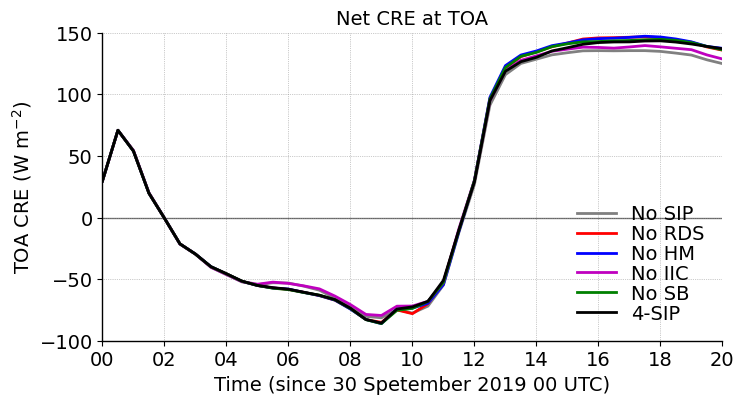

In [122]:
plt.figure(figsize=(8, 4))

lnwdth=2
fontsize=14

plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

plt.plot(ds_nosip.time, toa_net_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, toa_net_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, toa_net_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, toa_net_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, toa_net_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt.plot(ds_4sip.time, toa_net_cre_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#+4, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-100,150)
plt.yticks(fontsize=fontsize)
plt.ylabel('TOA CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('Net CRE at TOA', fontsize=fontsize)#, fontweight='bold')
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.show()


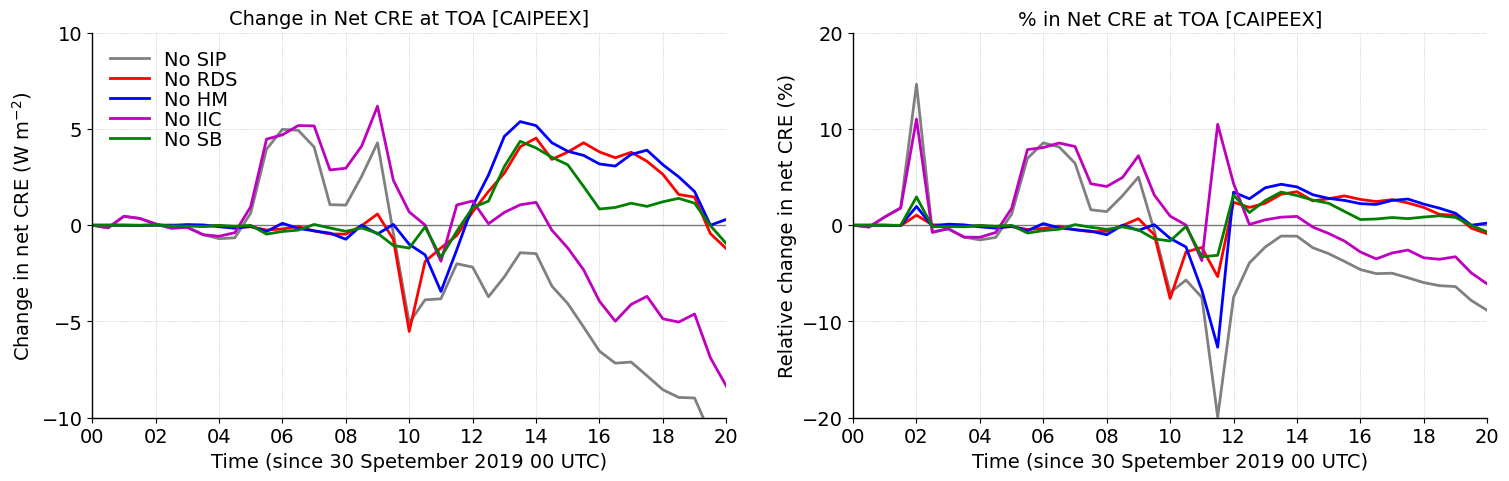

In [143]:
plt.figure(figsize=(18, 5))

lnwdth=2
fontsize=14

plt.subplot(1,2,1)

plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

plt.plot(ds_nosip.time, del_toa_net_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, del_toa_net_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, del_toa_net_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, del_toa_net_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, del_toa_net_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-10,10)
plt.yticks([-10, -5, 0, 5, 10], fontsize=fontsize)
plt.ylabel('Change in net CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('Change in Net CRE at TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)


plt.subplot(1,2,2)

plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

plt.plot(ds_nosip.time, per_del_toa_net_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, per_del_toa_net_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, per_del_toa_net_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, per_del_toa_net_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, per_del_toa_net_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-20,20)
plt.yticks([-20, -10, 0, 10, 20], fontsize=fontsize)
plt.ylabel('Relative change in net CRE (%)', fontsize=fontsize)#, fontweight='bold')
plt.title('% in Net CRE at TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)

plt.show()


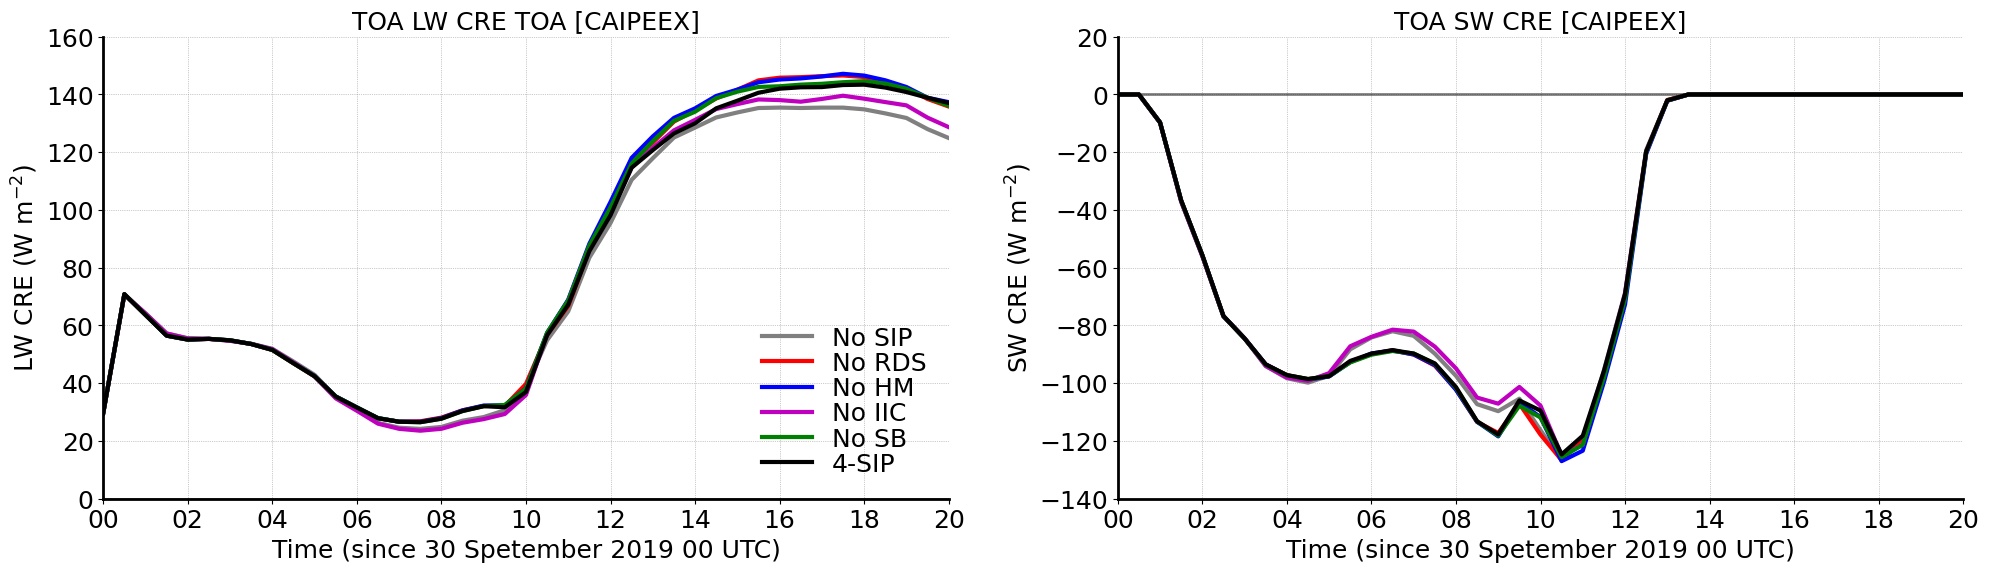

In [138]:


plt.figure(figsize=(24, 6))

lnwdth=3
fontsize=18

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, toa_lw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, toa_lw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, toa_lw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, toa_lw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, toa_lw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt.plot(ds_4sip.time, toa_lw_cre_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(0,160)
plt.yticks(fontsize=fontsize)
plt.ylabel('LW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('TOA LW CRE TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, toa_sw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, toa_sw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, toa_sw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, toa_sw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, toa_sw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt.plot(ds_4sip.time, toa_sw_cre_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-140,20)
plt.yticks(fontsize=fontsize)
plt.ylabel('SW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('TOA SW CRE [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


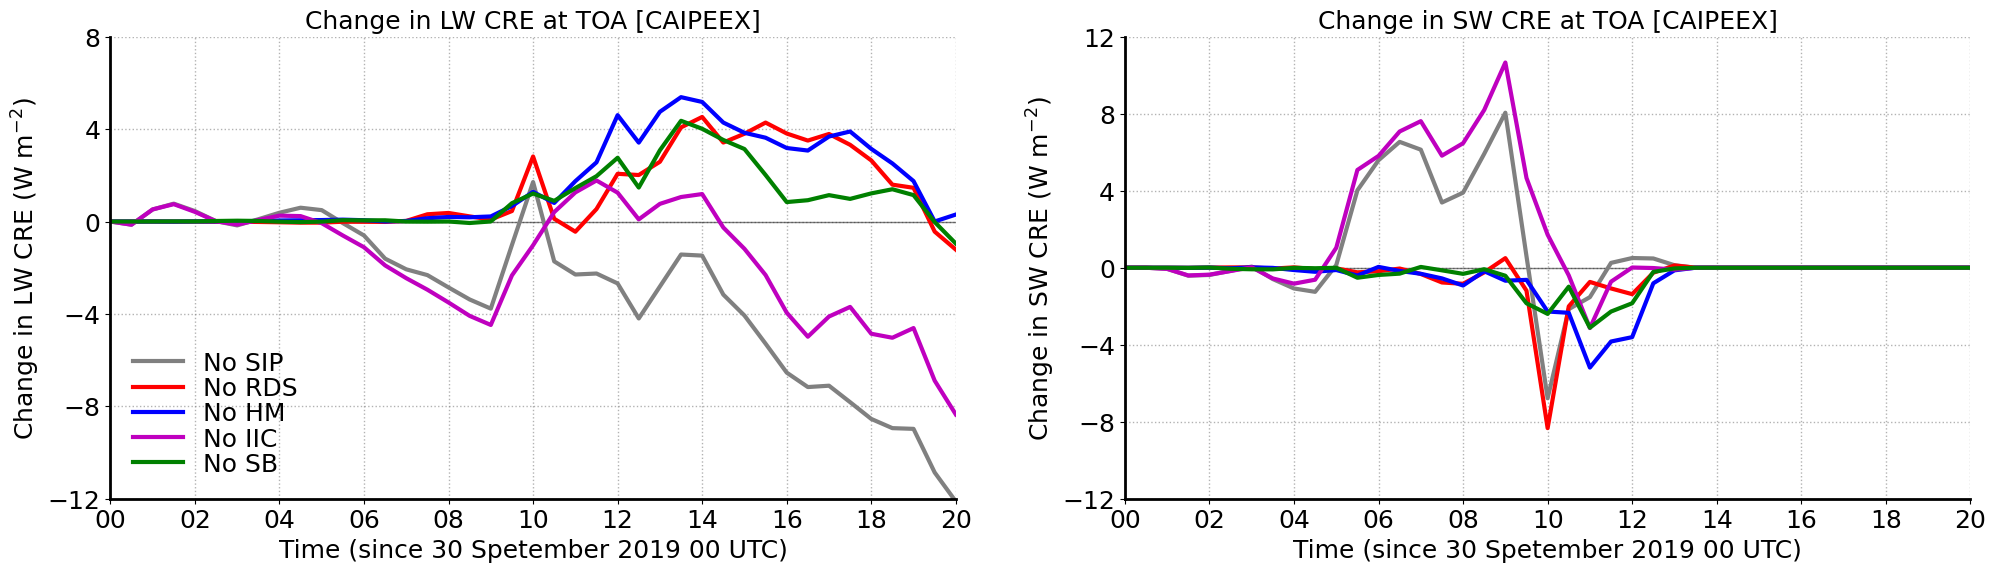

In [146]:

plt.figure(figsize=(24, 6))

lnwdth=3
fontsize=18

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

plt.plot(ds_nosip.time, del_toa_lw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, del_toa_lw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, del_toa_lw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, del_toa_lw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, del_toa_lw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-12, 8)
plt.yticks([-12, -8, -4, 0, 4, 8], fontsize=fontsize)
plt.ylabel('Change in LW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('Change in LW CRE at TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')

plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')

plt.grid(True, linestyle=':', linewidth=1, color='grey',alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)


plt.subplot(1,2,2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

plt.plot(ds_nosip.time, del_toa_sw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, del_toa_sw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, del_toa_sw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, del_toa_sw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, del_toa_sw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-12,12)
plt.yticks([-12, -8, -4, 0, 4, 8, 12], fontsize=fontsize)
plt.ylabel('Change in SW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('Change in SW CRE at TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')

#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')

plt.grid(True, linestyle=':', linewidth=1, color='grey',alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

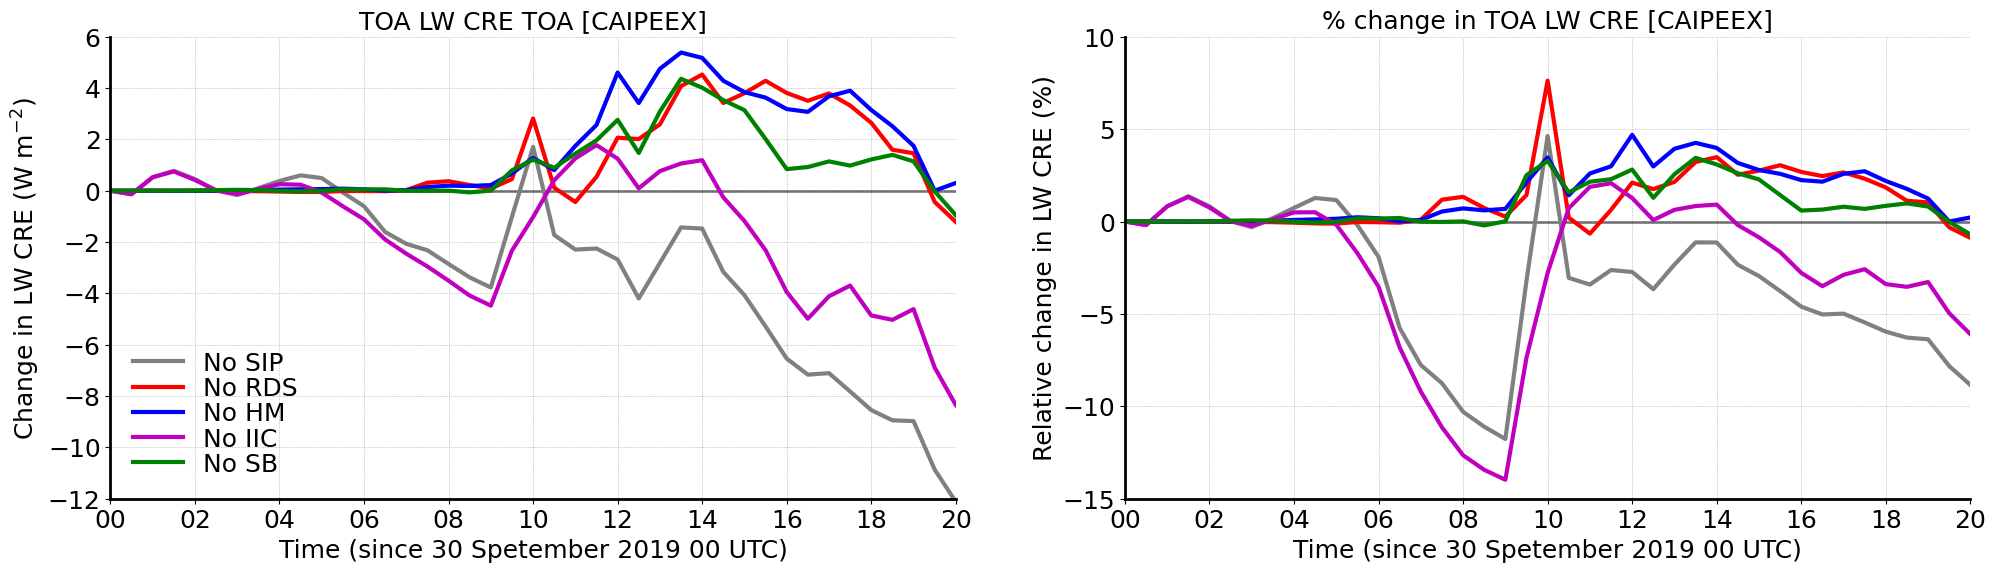

In [128]:


plt.figure(figsize=(24, 6))

lnwdth=3
fontsize=18

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, del_toa_lw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, del_toa_lw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, del_toa_lw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, del_toa_lw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, del_toa_lw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-12,6)
plt.yticks(fontsize=fontsize)
plt.ylabel('Change in LW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('TOA LW CRE TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, per_del_toa_lw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, per_del_toa_lw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, per_del_toa_lw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, per_del_toa_lw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, per_del_toa_lw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-15,10)
plt.yticks(fontsize=fontsize)
plt.ylabel('Relative change in LW CRE (%)', fontsize=fontsize)#, fontweight='bold')
plt.title('% change in TOA LW CRE [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


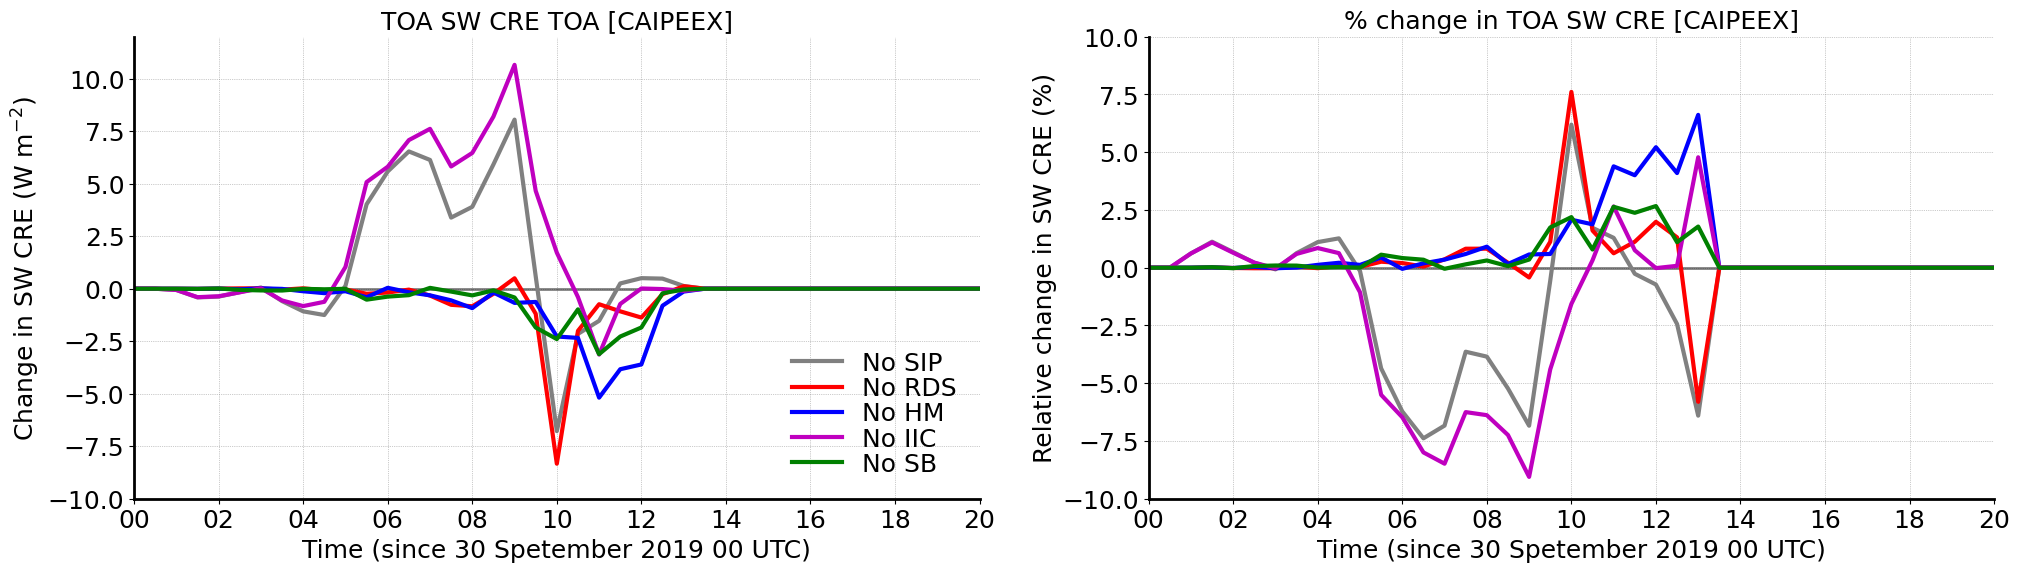

In [135]:


plt.figure(figsize=(24, 6))

lnwdth=3
fontsize=18

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, del_toa_sw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, del_toa_sw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, del_toa_sw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, del_toa_sw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, del_toa_sw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-10,12)
plt.yticks(fontsize=fontsize)
plt.ylabel('Change in SW CRE (W m$^{-2}$)', fontsize=fontsize)#, fontweight='bold')
plt.title('TOA SW CRE TOA [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.5)

plt.plot(ds_nosip.time, per_del_toa_sw_cre_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time, per_del_toa_sw_cre_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(ds_nohm.time, per_del_toa_sw_cre_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time, per_del_toa_sw_cre_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time, per_del_toa_sw_cre_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 30 Spetember 2019 00 UTC)', fontsize=fontsize)#, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
start_date = datetime(2019, 9, 30, 0, 0) 
end_date = datetime(2019, 9, 30, 20, 0)

plt.xlim(start_date, end_date)
plt.xticks(fontsize=fontsize)
plt.ylim(-10,10)
plt.yticks(fontsize=fontsize)
plt.ylabel('Relative change in SW CRE (%)', fontsize=fontsize)#, fontweight='bold')
plt.title('% change in TOA SW CRE [CAIPEEX]', fontsize=fontsize)#, fontweight='bold')
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey',alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


## Radiative Heating Rates

In [17]:


#mean_ht_nosip = 1.e-3*ds_nosip.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

#mean_ht_4sip = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
#mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

#mean_ht_norf = 1.e-3*ds_norf.z_mc.mean(dim=('time','ncells'))
#mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

#mean_ht_nohm = 1.e-3*ds_nohm.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

#mean_ht_nobr = 1.e-3*ds_nobr.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

#mean_ht_nosb = 1.e-3*ds_nosb.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# LW/SW heating rate with No SIP
mean_lwr_kperd_nosip = 86400.*ds_nosip.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nosip = 86400.*ds_nosip.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nosip = mean_lwr_kperd_nosip + mean_swr_kperd_nosip

# LW/SW heating rate with 4 SIP
mean_lwr_kperd_4sip = 86400.*ds_4sip.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_4sip = 86400.*ds_4sip.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_4sip = mean_lwr_kperd_4sip + mean_swr_kperd_4sip

# LW/SW heating rate with No RF
mean_lwr_kperd_norf = 86400.*ds_norf.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_norf = 86400.*ds_norf.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_norf = mean_lwr_kperd_norf + mean_swr_kperd_norf

# LW/SW heating rate with No HM
mean_lwr_kperd_nohm = 86400.*ds_nohm.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nohm = 86400.*ds_nohm.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nohm = mean_lwr_kperd_nohm + mean_swr_kperd_nohm

# LW/SW heating rate with No IIC
mean_lwr_kperd_nobr = 86400.*ds_nobr.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nobr = 86400.*ds_nobr.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nobr = mean_lwr_kperd_nobr + mean_swr_kperd_nobr

# LW/SW heating rate with No SB
mean_lwr_kperd_nosb = 86400.*ds_nosb.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nosb = 86400.*ds_nosb.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nosb = mean_lwr_kperd_nosb + mean_swr_kperd_nosb

# Change in tot rad. heating w.r.t. control
del_tot_rad_kperd_norf = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_norf
del_tot_rad_kperd_nohm = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nohm
del_tot_rad_kperd_nobr = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nobr
del_tot_rad_kperd_nosb = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nosb
del_tot_rad_kperd_nosip = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nosip

# Change in LW rad. heating w.r.t. control
del_lwr_kperd_norf = mean_lwr_kperd_4sip-mean_lwr_kperd_norf
del_lwr_kperd_nohm = mean_lwr_kperd_4sip-mean_lwr_kperd_nohm
del_lwr_kperd_nobr = mean_lwr_kperd_4sip-mean_lwr_kperd_nobr
del_lwr_kperd_nosb = mean_lwr_kperd_4sip-mean_lwr_kperd_nosb
del_lwr_kperd_nosip = mean_lwr_kperd_4sip-mean_lwr_kperd_nosip

# Change in SW rad. heating w.r.t. control
del_swr_kperd_norf = mean_swr_kperd_4sip-mean_swr_kperd_norf
del_swr_kperd_nohm = mean_swr_kperd_4sip-mean_swr_kperd_nohm
del_swr_kperd_nobr = mean_swr_kperd_4sip-mean_swr_kperd_nobr
del_swr_kperd_nosb = mean_swr_kperd_4sip-mean_swr_kperd_nosb
del_swr_kperd_nosip = mean_swr_kperd_4sip-mean_swr_kperd_nosip

mean_tot_rad_kperd_nosip = mean_tot_rad_kperd_nosip.where(mean_tempc_nosip > -70)
mean_tot_rad_kperd_4sip = mean_tot_rad_kperd_4sip.where(mean_tempc_4sip > -70)
mean_tot_rad_kperd_norf = mean_tot_rad_kperd_norf.where(mean_tempc_norf > -70)
mean_tot_rad_kperd_nohm = mean_tot_rad_kperd_nohm.where(mean_tempc_nohm > -70)
mean_tot_rad_kperd_nobr = mean_tot_rad_kperd_nobr.where(mean_tempc_nobr > -70)
mean_tot_rad_kperd_nosb = mean_tot_rad_kperd_nosb.where(mean_tempc_nosb > -70)


In [18]:
# xarrays takes longer time to plot, convert them to numpy instead

variables = [mean_tot_rad_kperd_nosip, mean_tot_rad_kperd_4sip, mean_tot_rad_kperd_norf, mean_tot_rad_kperd_nohm, 
             mean_tot_rad_kperd_nobr, mean_tot_rad_kperd_nosb]
numpy_variables = [var.values for var in variables]

mean_tot_rad_kperd_nosip = numpy_variables[0]
mean_tot_rad_kperd_4sip = numpy_variables[1]
mean_tot_rad_kperd_norf = numpy_variables[2]
mean_tot_rad_kperd_nohm = numpy_variables[3]
mean_tot_rad_kperd_nobr = numpy_variables[4]
mean_tot_rad_kperd_nosb = numpy_variables[5]


In [19]:
variables = [mean_lwr_kperd_nosip, mean_lwr_kperd_4sip, mean_lwr_kperd_norf, mean_lwr_kperd_nohm, 
             mean_lwr_kperd_nobr, mean_lwr_kperd_nosb]
numpy_variables = [var.values for var in variables]

mean_lwr_kperd_nosip = numpy_variables[0]
mean_lwr_kperd_4sip = numpy_variables[1]
mean_lwr_kperd_norf = numpy_variables[2]
mean_lwr_kperd_nohm = numpy_variables[3]
mean_lwr_kperd_nobr = numpy_variables[4]
mean_lwr_kperd_nosb = numpy_variables[5]

variables = [mean_swr_kperd_nosip, mean_swr_kperd_4sip, mean_swr_kperd_norf, mean_swr_kperd_nohm, 
             mean_swr_kperd_nobr, mean_swr_kperd_nosb]
numpy_variables = [var.values for var in variables]

mean_swr_kperd_nosip = numpy_variables[0]
mean_swr_kperd_4sip = numpy_variables[1]
mean_swr_kperd_norf = numpy_variables[2]
mean_swr_kperd_nohm = numpy_variables[3]
mean_swr_kperd_nobr = numpy_variables[4]
mean_swr_kperd_nosb = numpy_variables[5]

In [20]:
mean_tot_rad_kperd_nosip

array([ 3.0731630e-01,            nan,            nan,            nan,
                  nan,            nan,  4.5168361e-01,  6.3938564e-01,
        8.3761001e-01,  9.3306684e-01,  9.9193084e-01,  9.0771151e-01,
        7.1301144e-01,  3.9487171e-01, -1.4104843e-02, -2.7762985e-01,
       -4.6414363e-01, -5.7777584e-01, -6.0831380e-01, -6.4950335e-01,
       -6.2091780e-01, -6.0579526e-01, -5.5618286e-01, -5.3594506e-01,
       -5.1290810e-01, -4.6663141e-01, -4.2008066e-01, -4.1251147e-01,
       -4.3897378e-01, -4.7222352e-01, -3.2439590e-01, -3.6341929e-01,
       -2.9180193e-01, -3.3737242e-01, -4.2290223e-01, -5.4395986e-01,
       -5.4374552e-01, -4.1136241e-01, -4.4602919e-01, -4.7955275e-01,
       -5.5144036e-01, -6.3185298e-01, -8.1128824e-01, -9.9921274e-01,
       -1.1415999e+00, -1.2470275e+00, -1.2065197e+00, -1.0790690e+00,
       -9.1043377e-01, -7.2613108e-01, -6.1161709e-01, -5.5607808e-01,
       -5.6082702e-01, -6.0279644e-01, -6.8303752e-01, -7.4806261e-01,
      

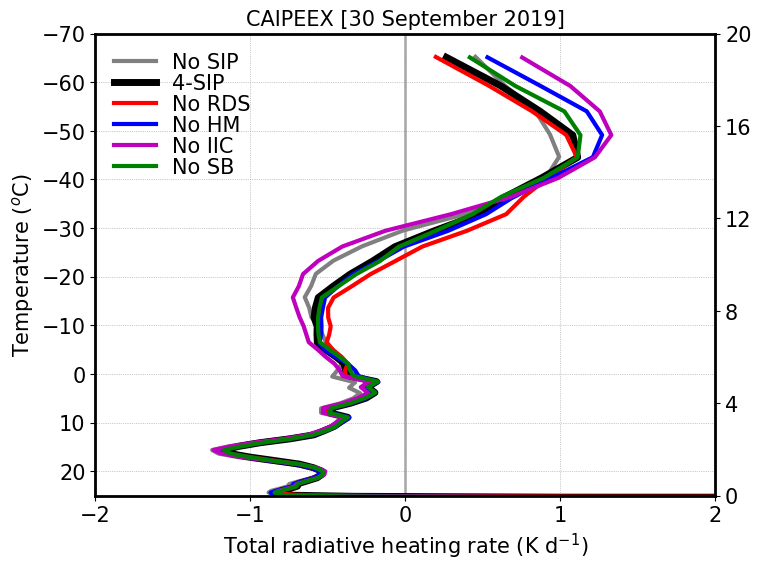

In [24]:
fontsize=15; lnwdth=3; alpha=0.6;

plt.figure(figsize=(8, 6)) 

plt1=plt.gca() 
plt2=plt1.twinx() 

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6) 

plt1.plot(mean_tot_rad_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP') 
plt1.plot(mean_tot_rad_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP') 
plt1.plot(mean_tot_rad_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS') 
plt1.plot(mean_tot_rad_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM') 
plt1.plot(mean_tot_rad_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC') 
plt1.plot(mean_tot_rad_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(mean_tot_rad_kperd_nosb, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(-2, 2) 
plt1.set_ylim(25, -70) 
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-2, -1, 0, 1, 2]) 
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70]) 
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize) 
plt1.tick_params(axis='y', labelsize=fontsize) 
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Total radiative heating rate (K d$^{-1}$)', fontsize=fontsize) 
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)

plt1.legend() 
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2) 
plt1.spines['right'].set_linewidth(2) 
plt1.spines['left'].set_linewidth(2) 
plt1.spines['bottom'].set_linewidth(2) 
plt.show()

#### The above plot should be the other way round, cooling at the top and warming in the middle levels

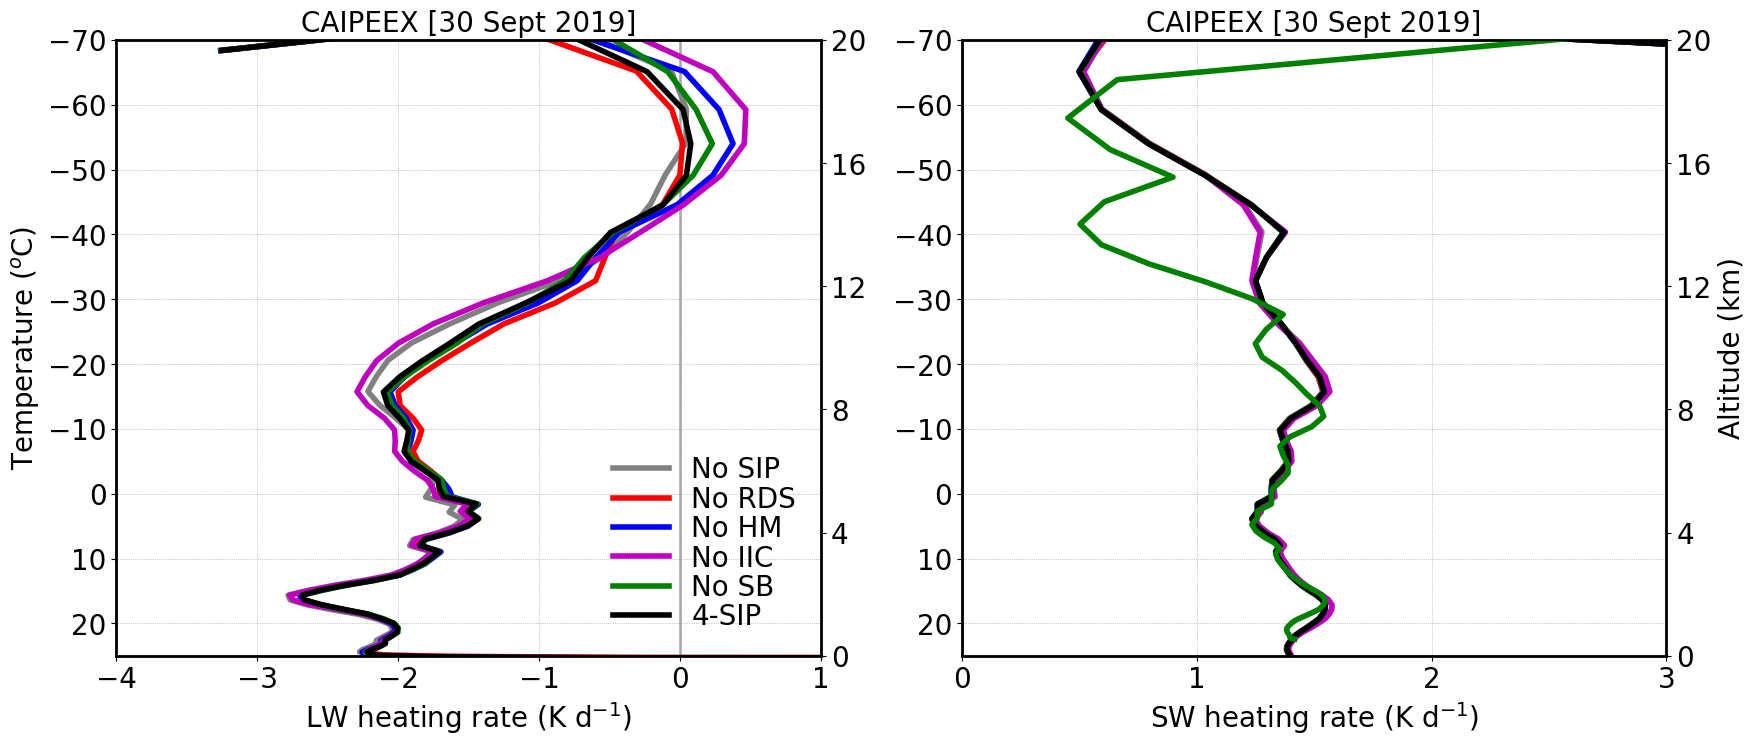

In [25]:

fontsize=20;
lnwdth=4;
alpha=0.8;

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_lwr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_lwr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_lwr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_lwr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_lwr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_lwr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt2.plot(mean_lwr_kperd_nosb, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.set_xlim(-4., 1)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-4, -3, -2, -1, 0, 1])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')

plt1.set_xlabel('LW heating rate (K d$^{-1}$)', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
#plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_visible(False)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.subplot(1,2,2)
plt1 = plt.gca()
plt2 = plt1.twinx()

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_swr_kperd_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_swr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_swr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_swr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_swr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_swr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt2.plot(mean_swr_kperd_nosb, mean_ht_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(0, 3)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([0, 1, 2, 3])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

#plt1.legend()
#plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')

plt1.set_xlabel('SW heating rate (K d$^{-1}$)', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
#plt2.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)

plt.show()


## Vertical velocity
### Change in updrafts and downdrafts

In [26]:
#mean_ht_nosip = 1.e-3*ds_nosip.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

#mean_ht_4sip = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
#mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

#mean_ht_norf = 1.e-3*ds_norf.z_mc.mean(dim=('time','ncells'))
#mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

#mean_ht_nohm = 1.e-3*ds_nohm.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

#mean_ht_nobr = 1.e-3*ds_nobr.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

#mean_ht_nosb = 1.e-3*ds_nosb.z_mc.mean(dim=('time','ncells'))
#mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

mean_tot_w_nosip = ds_nosip.w_vel.where(abs(ds_nosip.w_vel) > 0.).mean(dim=('time','ncells'))
mean_tot_w_4sip = ds_4sip.w_vel.where(abs(ds_4sip.w_vel) > 0.).mean(dim=('time','ncells'))
mean_tot_w_norf = ds_norf.w_vel.where(abs(ds_norf.w_vel) > 0.).mean(dim=('time','ncells'))
mean_tot_w_nohm = ds_nohm.w_vel.where(abs(ds_nohm.w_vel) > 0.).mean(dim=('time','ncells'))
mean_tot_w_nobr = ds_nobr.w_vel.where(abs(ds_nobr.w_vel) > 0.).mean(dim=('time','ncells'))
mean_tot_w_nosb = ds_nosb.w_vel.where(abs(ds_nosb.w_vel) > 0.).mean(dim=('time','ncells'))

del_tot_w_nosip = mean_tot_w_4sip - mean_tot_w_nosip
del_tot_w_norf = mean_tot_w_4sip - mean_tot_w_norf
del_tot_w_nohm = mean_tot_w_4sip - mean_tot_w_nohm
del_tot_w_nobr = mean_tot_w_4sip - mean_tot_w_nobr
del_tot_w_nosb = mean_tot_w_4sip - mean_tot_w_nosb

mean_tot_w_nosip = mean_tot_w_nosip.where(mean_tempc_nosip > -70)
mean_tot_w_4sip = mean_tot_w_4sip.where(mean_tempc_4sip > -70)
mean_tot_w_norf = mean_tot_w_norf.where(mean_tempc_norf > -70)
mean_tot_w_nohm = mean_tot_w_nohm.where(mean_tempc_nohm > -70)
mean_tot_w_nobr = mean_tot_w_nobr.where(mean_tempc_nobr > -70)
mean_tot_w_nosb = mean_tot_w_nosb.where(mean_tempc_nosb > -70)

del_tot_w_nosip = del_tot_w_nosip.where(mean_tempc_nosip > -70)
del_tot_w_norf = del_tot_w_norf.where(mean_tempc_norf > -70)
del_tot_w_nohm = del_tot_w_nohm.where(mean_tempc_nohm > -70)
del_tot_w_nobr = del_tot_w_nobr.where(mean_tempc_nobr > -70)
del_tot_w_nosb = del_tot_w_nosb.where(mean_tempc_nosb > -70)



In [27]:
# xarrays takes longer time to plot, convert them to numpy instead

variables = [mean_tot_w_nosip, mean_tot_w_4sip, mean_tot_w_norf, mean_tot_w_nohm, mean_tot_w_nobr, mean_tot_w_nosb]
numpy_variables = [var.values for var in variables]

mean_tot_w_nosip = numpy_variables[0]
mean_tot_w_4sip = numpy_variables[1]
mean_tot_w_norf = numpy_variables[2]
mean_tot_w_nohm = numpy_variables[3]
mean_tot_w_nobr = numpy_variables[4]
mean_tot_w_nosb = numpy_variables[5]


In [28]:

del_tot_w_nosip = mean_tot_w_nosip - mean_tot_w_4sip
del_tot_w_norf = mean_tot_w_norf - mean_tot_w_4sip
del_tot_w_nohm = mean_tot_w_nohm - mean_tot_w_4sip
del_tot_w_nobr = mean_tot_w_nobr - mean_tot_w_4sip
del_tot_w_nosb = mean_tot_w_nosb - mean_tot_w_4sip

per_del_tot_w_nosip = 100*del_tot_w_nosip/mean_tot_w_4sip
per_del_tot_w_norf = 100*del_tot_w_norf/mean_tot_w_4sip
per_del_tot_w_nohm = 100*del_tot_w_nohm/mean_tot_w_4sip
per_del_tot_w_nobr = 100*del_tot_w_nobr/mean_tot_w_4sip
per_del_tot_w_nosb = 100*del_tot_w_nosb/mean_tot_w_4sip


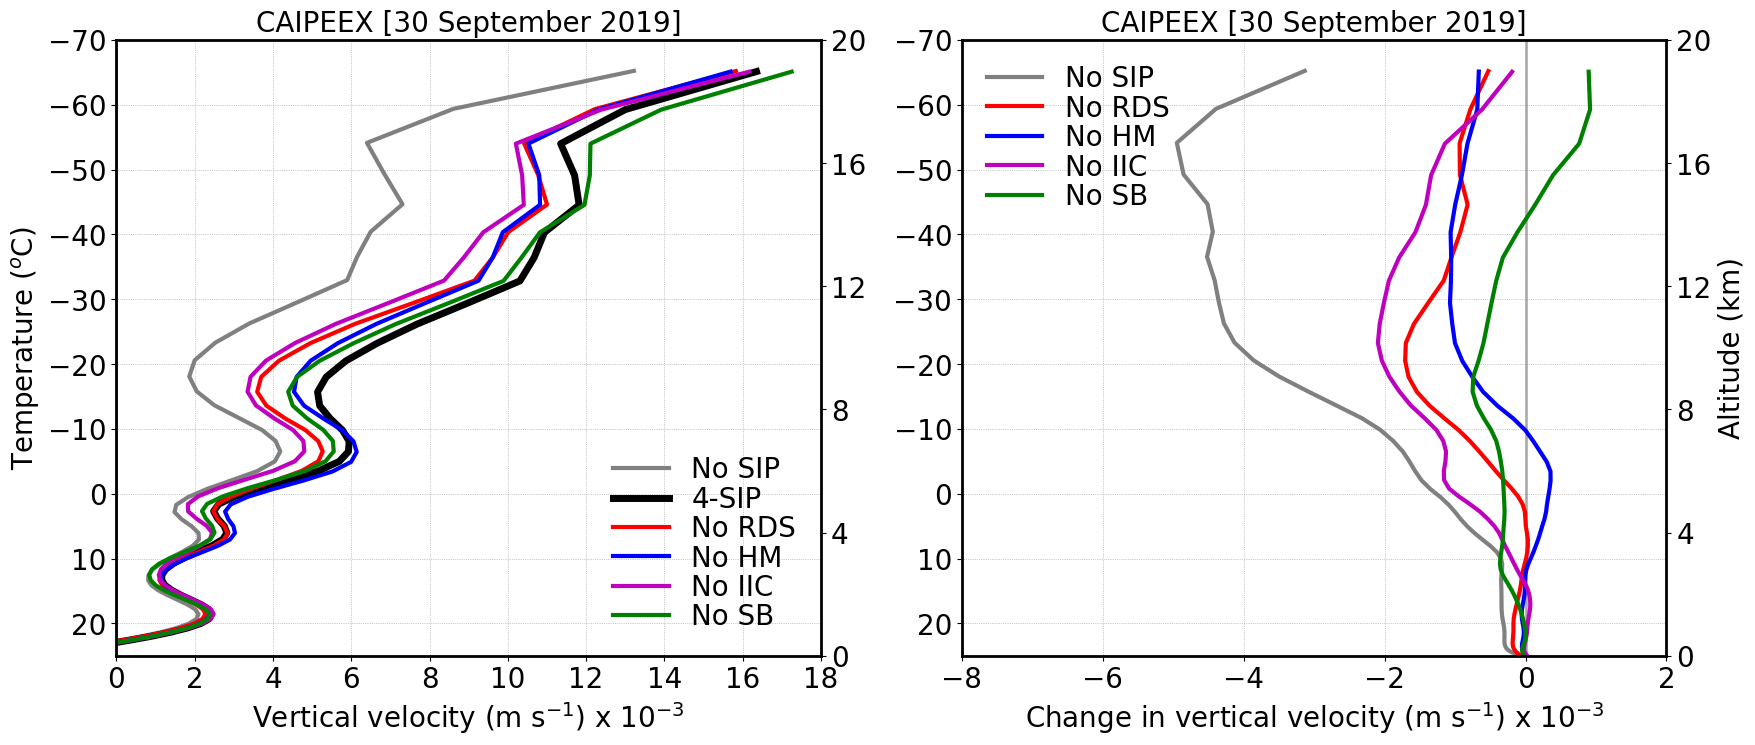

In [30]:


fontsize=20;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.e3
plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_tot_w_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_tot_w_4sip*fact, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt1.plot(mean_tot_w_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_tot_w_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_tot_w_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_tot_w_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(mean_tot_w_nosb*fact, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(0, 18)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Vertical velocity (m s$^{-1}$) x 10$^{-3}$', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)


plt.subplot(1,2,2)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.e3

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(del_tot_w_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(del_tot_w_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(del_tot_w_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(del_tot_w_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(del_tot_w_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(per_del_tot_w_nosb*fact, mean_ht_nobr, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(-8, 2)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-8, -6, -4, -2, 0, 2])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Change in vertical velocity (m s$^{-1}$) x 10$^{-3}$', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)
plt.show()


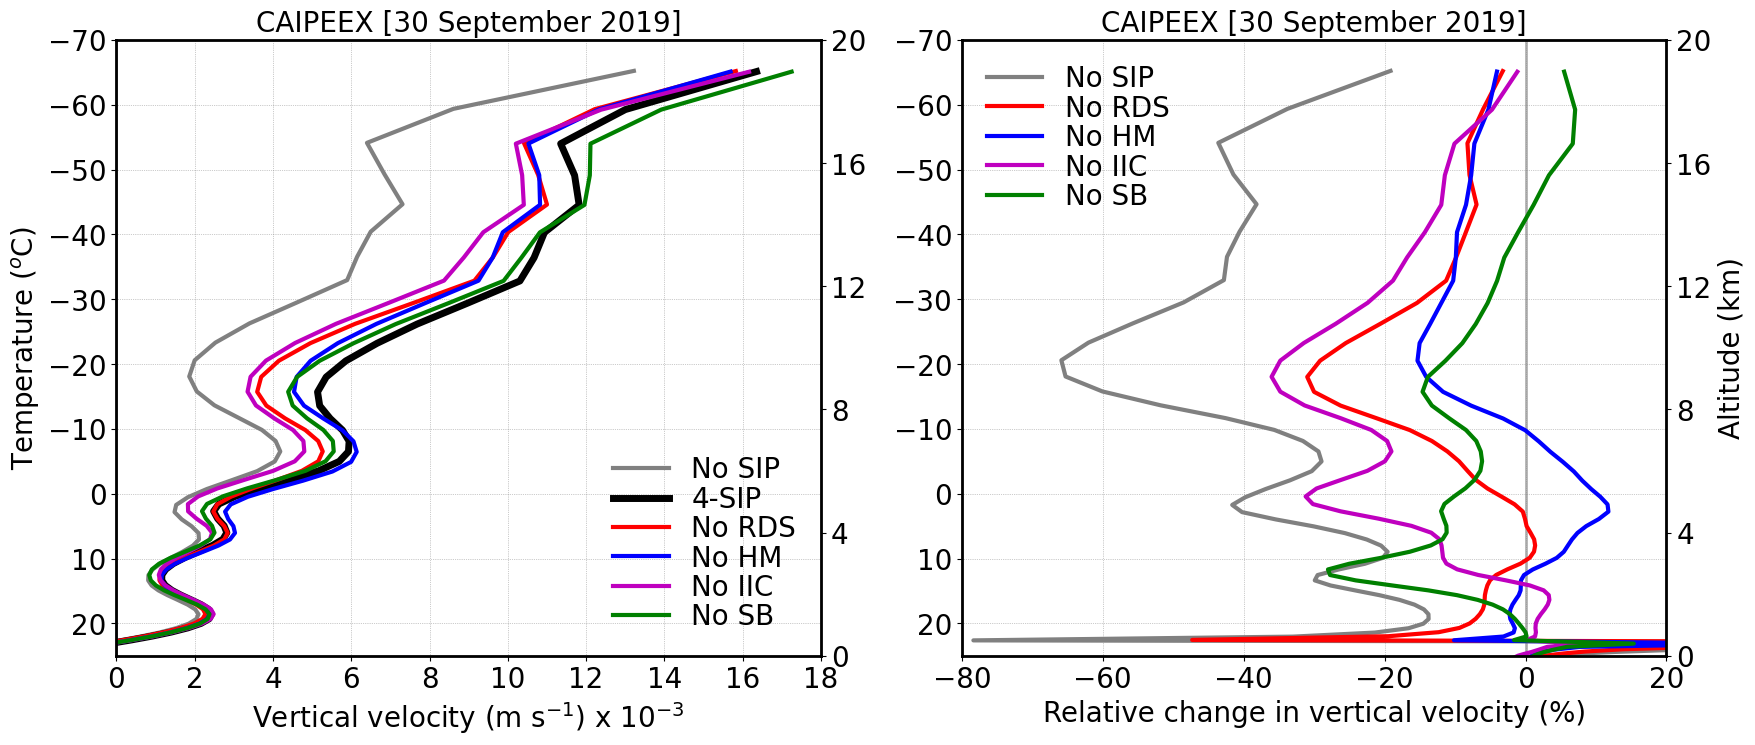

In [31]:


fontsize=20;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.e3
plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_tot_w_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_tot_w_4sip*fact, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt1.plot(mean_tot_w_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_tot_w_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_tot_w_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_tot_w_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(mean_tot_w_nosb*fact, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(0, 18)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Vertical velocity (m s$^{-1}$) x 10$^{-3}$', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)


plt.subplot(1,2,2)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(per_del_tot_w_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(per_del_tot_w_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(per_del_tot_w_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(per_del_tot_w_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(per_del_tot_w_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(per_del_tot_w_nosb*fact, mean_ht_nobr, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(-80, 20)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([-80, -60, -40, -20, 0, 20])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Relative change in vertical velocity (%)', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)
plt.show()


## Cloud cover

In [36]:

mean_tot_cld_cover_nosip = ds_nosip.clc.where(ds_nosip.tq > 0.).mean(dim=('time','ncells'))
mean_tot_cld_cover_4sip = ds_4sip.clc.where(ds_4sip.tq > 0.).mean(dim=('time','ncells'))
mean_tot_cld_cover_norf = ds_norf.clc.where(ds_norf.tq > 0.).mean(dim=('time','ncells'))
mean_tot_cld_cover_nohm = ds_nohm.clc.where(ds_nohm.tq > 0.).mean(dim=('time','ncells'))
mean_tot_cld_cover_nobr = ds_nobr.clc.where(ds_nobr.tq > 0.).mean(dim=('time','ncells'))
mean_tot_cld_cover_nosb = ds_nosb.clc.where(ds_nosb.tq > 0.).mean(dim=('time','ncells'))


In [37]:
# xarrays takes longer time to plot, convert them to numpy instead

variables = [mean_tot_cld_cover_nosip, mean_tot_cld_cover_4sip, mean_tot_cld_cover_norf, mean_tot_cld_cover_nohm, 
             mean_tot_cld_cover_nobr, mean_tot_cld_cover_nosb]
numpy_variables = [var.values for var in variables]

mean_tot_cld_cover_nosip = numpy_variables[0]
mean_tot_cld_cover_4sip = numpy_variables[1]
mean_tot_cld_cover_norf = numpy_variables[2]
mean_tot_cld_cover_nohm = numpy_variables[3]
mean_tot_cld_cover_nobr = numpy_variables[4]
mean_tot_cld_cover_nosb = numpy_variables[5]

In [43]:

del_tot_cld_cover_nosip = mean_tot_cld_cover_nosip - mean_tot_cld_cover_4sip
del_tot_cld_cover_norf = mean_tot_cld_cover_norf - mean_tot_cld_cover_4sip
del_tot_cld_cover_nohm = mean_tot_cld_cover_nohm - mean_tot_cld_cover_4sip
del_tot_cld_cover_nobr = mean_tot_cld_cover_nobr - mean_tot_cld_cover_4sip
del_tot_cld_cover_nosb = mean_tot_cld_cover_nosb - mean_tot_cld_cover_4sip

per_del_tot_cld_cover_nosip = 100*del_tot_cld_cover_nosip/mean_tot_cld_cover_4sip
per_del_tot_cld_cover_norf = 100*del_tot_cld_cover_norf/mean_tot_cld_cover_4sip
per_del_tot_cld_cover_nohm = 100*del_tot_cld_cover_nohm/mean_tot_cld_cover_4sip
per_del_tot_cld_cover_nobr = 100*del_tot_cld_cover_nobr/mean_tot_cld_cover_4sip
per_del_tot_cld_cover_nosb = 100*del_tot_cld_cover_nosb/mean_tot_cld_cover_4sip


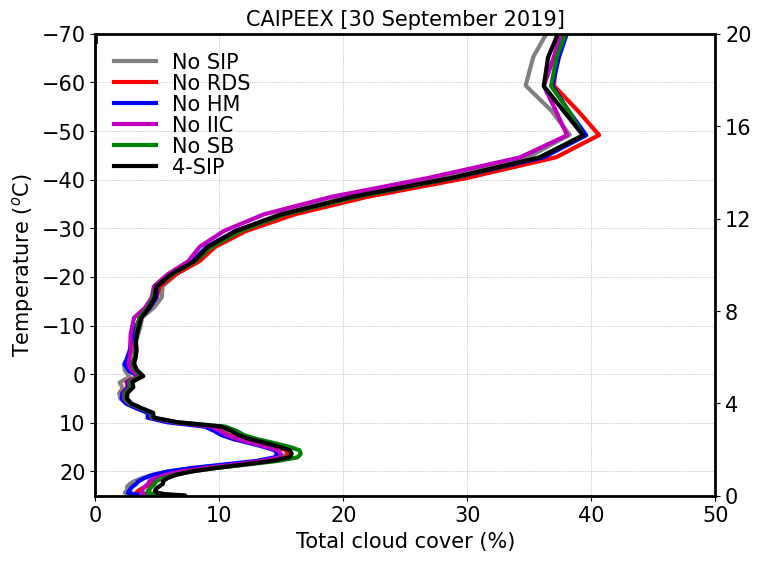

In [42]:
fontsize=15; lnwdth=3; alpha=0.6;

plt.figure(figsize=(8, 6)) 

plt1=plt.gca() 
plt2=plt1.twinx() 

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6) 

plt1.plot(mean_tot_cld_cover_nosip, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP') 
plt1.plot(mean_tot_cld_cover_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS') 
plt1.plot(mean_tot_cld_cover_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM') 
plt1.plot(mean_tot_cld_cover_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC') 
plt1.plot(mean_tot_cld_cover_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_tot_cld_cover_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth, label='4-SIP') 

plt2.plot(mean_tot_rad_kperd_nosb, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(0, 50) 
plt1.set_ylim(25, -70) 
plt2.set_ylim(0.5, 20)

#plt1.set_xticks([-2, -1, 0, 1, 2]) 
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70]) 
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize) 
plt1.tick_params(axis='y', labelsize=fontsize) 
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Total cloud cover (%)', fontsize=fontsize) 
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)

plt1.legend() 
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2) 
plt1.spines['right'].set_linewidth(2) 
plt1.spines['left'].set_linewidth(2) 
plt1.spines['bottom'].set_linewidth(2) 
plt.show()

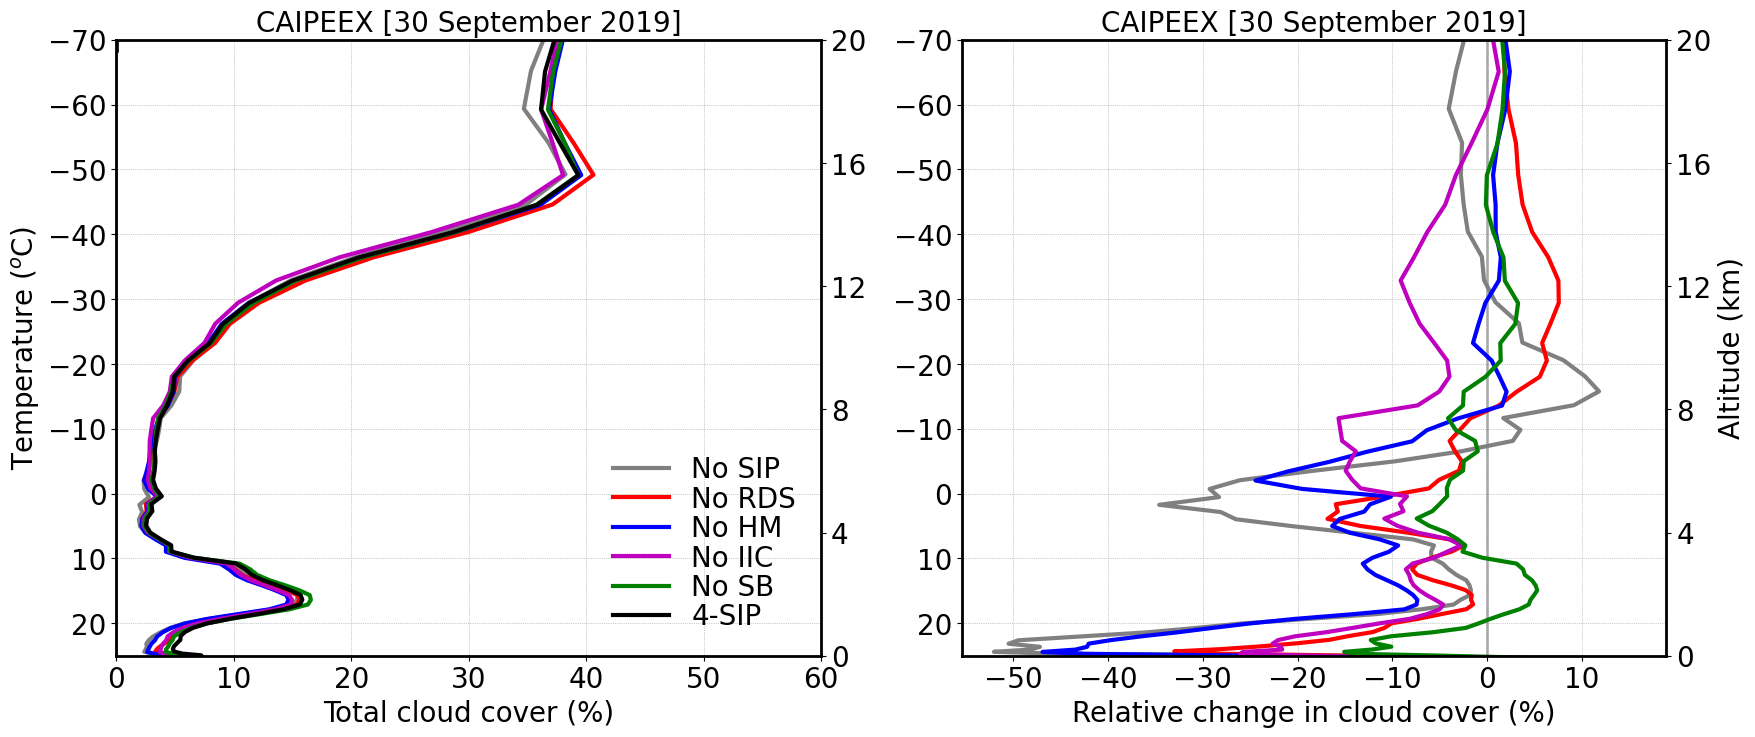

In [46]:


fontsize=20;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.
plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(mean_tot_cld_cover_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(mean_tot_cld_cover_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(mean_tot_cld_cover_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(mean_tot_cld_cover_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(mean_tot_cld_cover_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')
plt1.plot(mean_tot_cld_cover_4sip*fact, mean_tempc_4sip, 'k-', linewidth=lnwdth, label='4-SIP')

plt2.plot(mean_tot_w_nosb*fact, mean_ht_nosb, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

plt1.set_xlim(0, 60)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

plt1.set_xticks([0, 10, 20, 30, 40, 50 ,60])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Total cloud cover (%)', fontsize=fontsize)
plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)

plt1.legend()
plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)


plt.subplot(1,2,2)

plt1=plt.gca()
plt2=plt1.twinx()

fact = 1.

plt1.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt1.plot(per_del_tot_cld_cover_nosip*fact, mean_tempc_nosip, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt1.plot(per_del_tot_cld_cover_norf*fact, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt1.plot(per_del_tot_cld_cover_nohm*fact, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt1.plot(per_del_tot_cld_cover_nobr*fact, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt1.plot(per_del_tot_cld_cover_nosb*fact, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt2.plot(per_del_tot_w_nosb*fact, mean_ht_nobr, '-', color='none', linewidth=lnwdth)#, label='No SB')

plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)

#plt1.set_xlim(-80, 20)
plt1.set_ylim(25, -70)
plt2.set_ylim(0.5, 20)

#plt1.set_xticks([-80, -60, -40, -20, 0, 20])
plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
plt2.set_yticks([0, 4, 8, 12, 16, 20])

plt1.tick_params(axis='x', labelsize=fontsize)
plt1.tick_params(axis='y', labelsize=fontsize)
plt2.tick_params(axis='y', labelsize=fontsize)

plt1.set_xlabel('Relative change in cloud cover (%)', fontsize=fontsize)
#plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt2.set_ylabel('Altitude (km)', fontsize=fontsize)

#plt1.legend()
#plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')

plt.title('CAIPEEX [30 September 2019]', fontsize=fontsize)

plt1.spines['top'].set_linewidth(2)
plt1.spines['right'].set_linewidth(2)
plt1.spines['left'].set_linewidth(2)
plt1.spines['bottom'].set_linewidth(2)
plt.show()


### Surface rainfall

In [ ]:
acc_precip_nosip = ds_nosip.tot_prec.mean('ncells')
acc_precip_4sip = ds_4sip.tot_prec.mean('ncells')
acc_precip_nohm = ds_nohm.tot_prec.mean('ncells')
acc_precip_nobr = ds_nobr.tot_prec.mean('ncells')
acc_precip_norf = ds_norf.tot_prec.mean('ncells')
acc_precip_nosb = ds_nosb.tot_prec.mean('ncells')

In [48]:
del_prec_nosip = ds_nosip.tot_prec.diff('time')
del_prec_4sip = ds_4sip.tot_prec.diff('time')
del_prec_norf = ds_norf.tot_prec.diff('time')
del_prec_nohm = ds_nohm.tot_prec.diff('time')
del_prec_nobr = ds_nobr.tot_prec.diff('time')
del_prec_nosb = ds_nosb.tot_prec.diff('time')

precip_rate_nosip = del_prec_nosip/0.5
precip_rate_4sip = del_prec_4sip/0.5
precip_rate_norf = del_prec_norf/0.5            # output is over 30 min
precip_rate_nohm = del_prec_nohm/0.5
precip_rate_nobr = del_prec_nobr/0.5
precip_rate_nosb = del_prec_nosb/0.5

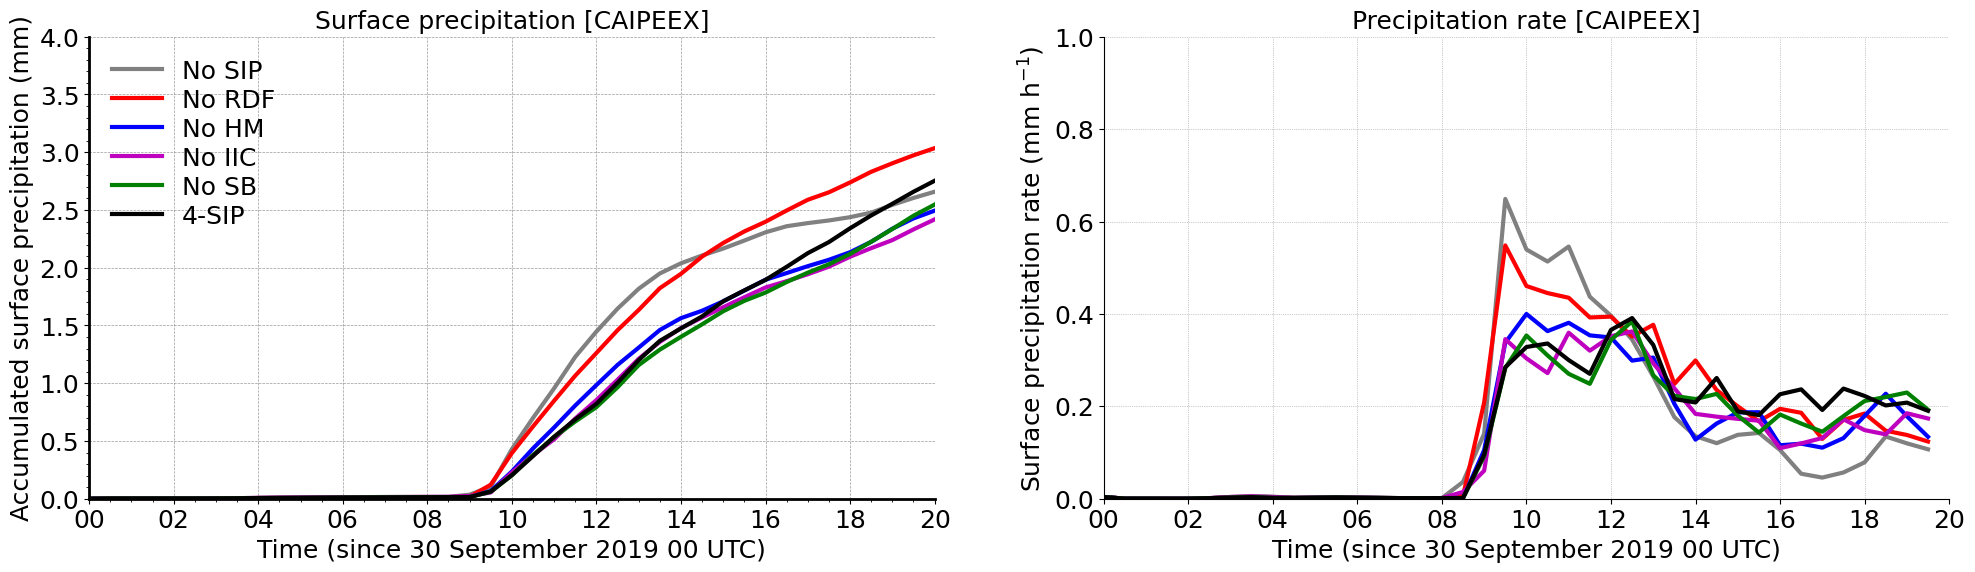

In [54]:


fontsize=18
linwdth = 3
plt.figure(figsize=(24, 6))

plt.subplot(1,2,1)
plt.plot(ds_nosip.time, acc_precip_nosip, "-", color='grey', label="No SIP", linewidth = linwdth)
plt.plot(ds_norf.time, acc_precip_norf, "r-", label="No RDF", linewidth = linwdth)
plt.plot(ds_nohm.time, acc_precip_nohm, "b-", label="No HM", linewidth = linwdth)
plt.plot(ds_nobr.time, acc_precip_nobr, "m-", label="No IIC", linewidth = linwdth)
plt.plot(ds_nosb.time, acc_precip_nosb, "g-", label="No SB", linewidth = linwdth)
plt.plot(ds_4sip.time, acc_precip_4sip, "k-", label="4-SIP", linewidth = linwdth)

plt.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.8)
plt.minorticks_on()
plt.ylim(0, 4)
plt.xlabel('Time (since 30 September 2019 00 UTC)', fontsize=fontsize)
plt.ylabel('Accumulated surface precipitation (mm)', fontsize=fontsize)
start_date = datetime(2019, 9, 30, 0, 0)  # Start at 00 UTC on 10 May 2011
end_date = datetime(2019, 9, 30, 20, 0)
plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Surface precipitation [CAIPEEX]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(ds_nosip.time[:-1], precip_rate_nosip.mean('ncells'), '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time[:-1], precip_rate_norf.mean('ncells'), 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(ds_nohm.time[:-1], precip_rate_nohm.mean('ncells'), 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time[:-1], precip_rate_nobr.mean('ncells'), 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time[:-1], precip_rate_nosb.mean('ncells'), 'g-', linewidth=lnwdth, label='No SB')
plt.plot(ds_4sip.time[:-1], precip_rate_4sip.mean('ncells'), 'k-', linewidth=lnwdth, label='4-SIP')

plt.ylim(0, 1)
plt.xlabel('Time (since 30 September 2019 00 UTC)', fontsize=fontsize)
plt.ylabel('Surface precipitation rate (mm h$^{-1}$)', fontsize=fontsize)
start_date = datetime(2019, 9, 30, 0, 0)  # Start at 00 UTC on 10 May 2011
end_date = datetime(2019, 9, 30, 20, 0)
plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Precipitation rate [CAIPEEX]', fontsize=fontsize)
#plt.legend()
#plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


## Ice number concentrations

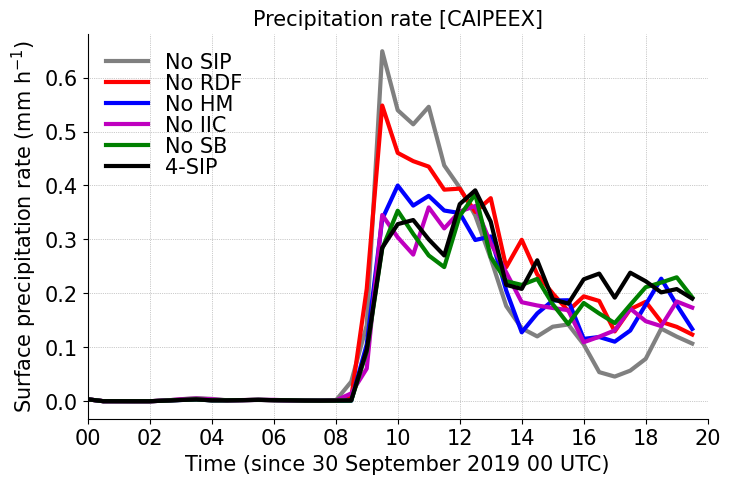

In [50]:
fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 5))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(ds_nosip.time[:-1], precip_rate_nosip.mean('ncells'), '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_norf.time[:-1], precip_rate_norf.mean('ncells'), 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(ds_nohm.time[:-1], precip_rate_nohm.mean('ncells'), 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time[:-1], precip_rate_nobr.mean('ncells'), 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time[:-1], precip_rate_nosb.mean('ncells'), 'g-', linewidth=lnwdth, label='No SB')
plt.plot(ds_4sip.time[:-1], precip_rate_4sip.mean('ncells'), 'k-', linewidth=lnwdth, label='4-SIP')

plt.ylim(0, 1)
plt.xlabel('Time (since 30 September 2019 00 UTC)', fontsize=fontsize)
plt.ylabel('Surface precipitation rate (mm h$^{-1}$)', fontsize=fontsize)
start_date = datetime(2019, 9, 30, 0, 0)  # Start at 00 UTC on 10 May 2011
end_date = datetime(2019, 9, 30, 20, 0)
plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Precipitation rate [CAIPEEX]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()

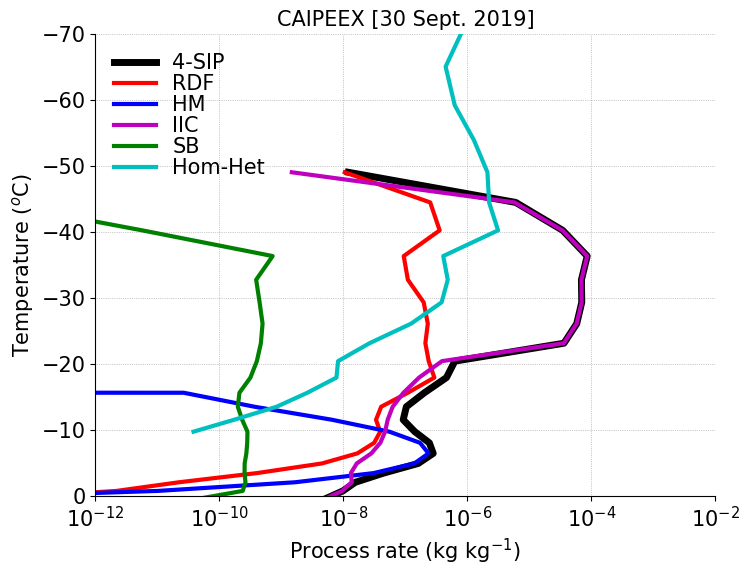

In [7]:

thres_q = 1.e-12
qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_sec, np.nan)
dqi_sec_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_ds, np.nan)
dqi_rf_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_rs, np.nan)
dqi_hm_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_br, np.nan)
dqi_br_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_snow_sbf, np.nan)
dqi_snow_sb = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_graup_sbf, np.nan)
dqi_graup_sb = qi_filt.mean(dim=('time','ncells'))

dqi_tot_sb = dqi_snow_sb + dqi_graup_sb

qi_filt = xr.where(ds_4sip.d_qi_homhet > thres_q, ds_4sip.d_qi_homhet, np.nan)
dqi_homhet_tot = qi_filt.mean(dim=('time', 'ncells'))


avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


dqi_sec_tot = dqi_sec_tot.where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.where(avg_tempc > -50)

dqi_sec_tot = dqi_sec_tot.values #where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.values   #where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.values   #where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.values   #where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.values   #where(avg_tempc > -50)
dqi_homhet_tot = dqi_homhet_tot.values
avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(dqi_sec_tot, avg_tempc, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(dqi_rf_tot, avg_tempc, 'r-', linewidth=lnwdth, label='RDF')
plt.plot(dqi_hm_tot, avg_tempc, 'b-', linewidth=lnwdth, label='HM')
plt.plot(dqi_br_tot, avg_tempc, 'm-', linewidth=lnwdth, label='IIC')
plt.plot(dqi_tot_sb, avg_tempc, 'g-', linewidth=lnwdth, label='SB')
plt.plot(dqi_homhet_tot, avg_tempc, 'c-', linewidth=lnwdth, label='Hom-Het')

plt.xscale('log')
plt.xlim(1.e-12, 1.e-2)
plt.ylim(0, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


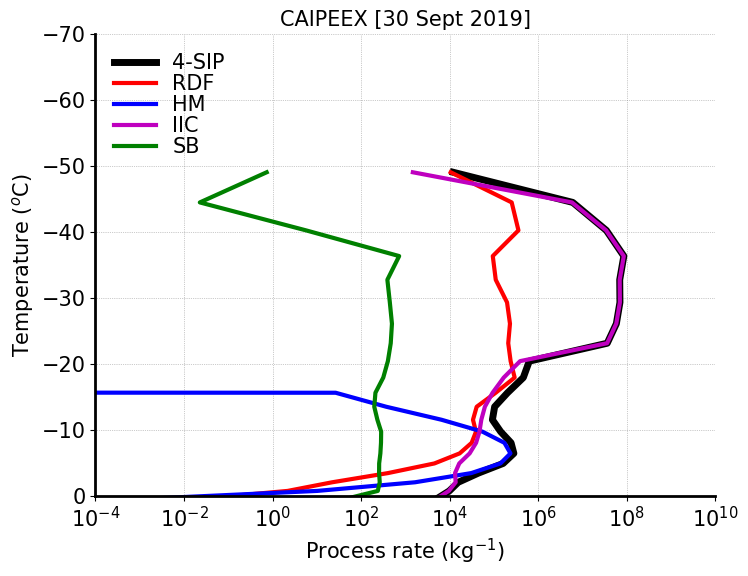

In [12]:

thres_q = 1.e-12
qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_sec, np.nan)
dqi_sec_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_ds, np.nan)
dqi_rf_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_rs, np.nan)
dqi_hm_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_br, np.nan)
dqi_br_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_snow_sbf, np.nan)
dqi_snow_sb = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_graup_sbf, np.nan)
dqi_graup_sb = qi_filt.mean(dim=('time','ncells'))

dqi_tot_sb = dqi_snow_sb + dqi_graup_sb

qi_filt = xr.where(ds_4sip.d_qi_homhet > thres_q, ds_4sip.d_qi_homhet, np.nan)
dqi_homhet_tot = qi_filt.mean(dim=('time', 'ncells'))


avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


dqi_sec_tot = dqi_sec_tot.where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.where(avg_tempc > -50)

dqi_sec_tot = dqi_sec_tot.values #where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.values   #where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.values   #where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.values   #where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.values   #where(avg_tempc > -50)
dqi_homhet_tot = dqi_homhet_tot.values
avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;
st = 3
plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(dqi_sec_tot, avg_tempc, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(dqi_rf_tot, avg_tempc, 'r-', linewidth=lnwdth, label='RDF')
plt.plot(dqi_hm_tot, avg_tempc, 'b-', linewidth=lnwdth, label='HM')
plt.plot(dqi_br_tot, avg_tempc, 'm-', linewidth=lnwdth, label='IIC')
plt.plot(dqi_tot_sb, avg_tempc, 'g-', linewidth=lnwdth, label='SB')
#plt.plot(dqi_homhet_tot, avg_tempc, 'c-', linewidth=lnwdth, label='Hom-Het')

plt.xscale('log')
plt.xlim(1.e-4, 1.e10)
plt.ylim(0, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


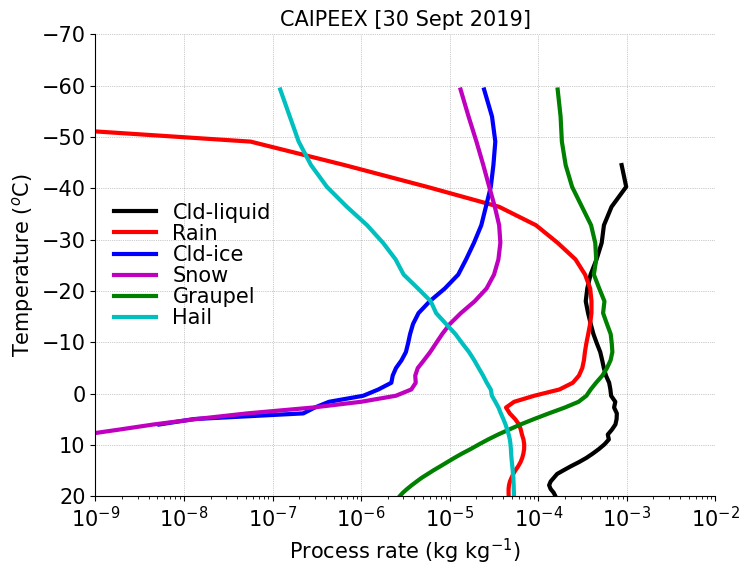

In [9]:

thres_q = 1.e-12
filt_q = xr.where(ds_4sip.qr > thres_q, ds_4sip.qr, np.nan)
avg_qr = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qc > thres_q, ds_4sip.qc, np.nan)
avg_qc = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qi > thres_q, ds_4sip.qi, np.nan)
avg_qi = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qs > thres_q, ds_4sip.qs, np.nan)
avg_qs = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qg, np.nan)
avg_qg = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qh, np.nan)
avg_qh = filt_q.mean(dim=('time','ncells'))

avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

avg_qr = avg_qr.where(avg_tempc > -60)
avg_qc = avg_qc.where(avg_tempc > -60)
avg_qi = avg_qi.where(avg_tempc > -60)
avg_qs = avg_qs.where(avg_tempc > -60)
avg_qg = avg_qg.where(avg_tempc > -60)
avg_qh = avg_qh.where(avg_tempc > -60)

avg_qr = avg_qr.values
avg_qc = avg_qc.values
avg_qi = avg_qi.values
avg_qs = avg_qs.values
avg_qg = avg_qg.values
avg_qh = avg_qh.values

avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(avg_qc, avg_tempc, 'k-', linewidth=lnwdth, label='Cld-liquid')
plt.plot(avg_qr, avg_tempc, 'r-', linewidth=lnwdth, label='Rain')
plt.plot(avg_qi, avg_tempc, 'b-', linewidth=lnwdth, label='Cld-ice')
plt.plot(avg_qs, avg_tempc, 'm-', linewidth=lnwdth, label='Snow')
plt.plot(avg_qg, avg_tempc, 'g-', linewidth=lnwdth, label='Graupel')
plt.plot(avg_qh, avg_tempc, 'c-', linewidth=lnwdth, label='Hail')

plt.xscale('log')
plt.xlim(1.e-9, 1.e-2)
plt.ylim(20, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='best')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()

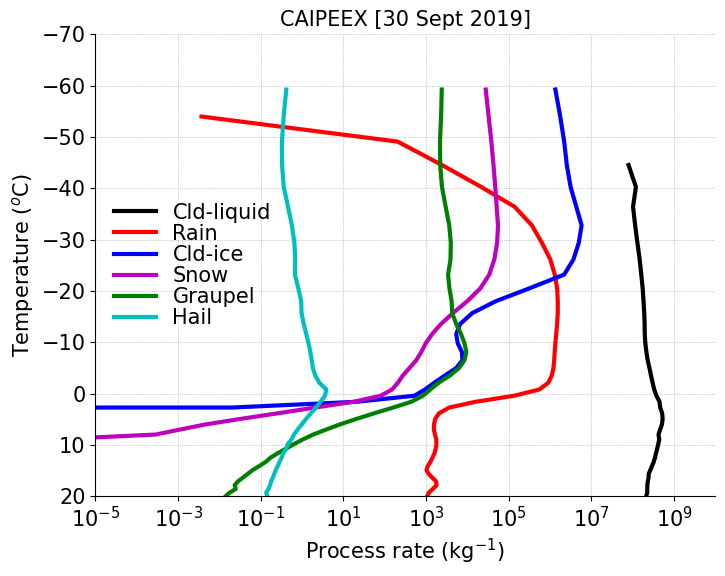

In [11]:

thres_q = 1.e-12
filt_q = xr.where(ds_4sip.qr > thres_q, ds_4sip.qnr, np.nan)
avg_qnr = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qc > thres_q, ds_4sip.qnc, np.nan)
avg_qnc = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qi > thres_q, ds_4sip.qni, np.nan)
avg_qni = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qs > thres_q, ds_4sip.qns, np.nan)
avg_qns = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qng, np.nan)
avg_qng = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qnh, np.nan)
avg_qnh = filt_q.mean(dim=('time','ncells'))

avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

avg_qnr = avg_qnr.where(avg_tempc > -60)
avg_qnc = avg_qnc.where(avg_tempc > -60)
avg_qni = avg_qni.where(avg_tempc > -60)
avg_qns = avg_qns.where(avg_tempc > -60)
avg_qng = avg_qng.where(avg_tempc > -60)
avg_qnh = avg_qnh.where(avg_tempc > -60)

avg_qnr = avg_qnr.values
avg_qnc = avg_qnc.values
avg_qni = avg_qni.values
avg_qns = avg_qns.values
avg_qng = avg_qng.values
avg_qnh = avg_qnh.values

avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(avg_qnc, avg_tempc, 'k-', linewidth=lnwdth, label='Cld-liquid')
plt.plot(avg_qnr, avg_tempc, 'r-', linewidth=lnwdth, label='Rain')
plt.plot(avg_qni, avg_tempc, 'b-', linewidth=lnwdth, label='Cld-ice')
plt.plot(avg_qns, avg_tempc, 'm-', linewidth=lnwdth, label='Snow')
plt.plot(avg_qng, avg_tempc, 'g-', linewidth=lnwdth, label='Graupel')
plt.plot(avg_qnh, avg_tempc, 'c-', linewidth=lnwdth, label='Hail')

plt.xscale('log')
plt.xlim(1.e-2, 1.e10)
plt.ylim(20, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='best')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import dask.array as da
import time

thres_q = 1.e-12

start = time.time()

avg_ht = 1.e-3*ds_4sip.z_mc.mean(dim=('time', 'ncells'))

def process_variable(var, ref_var, ds):
    """Processes variable with dask-backed operations"""
    avg_tempc = ds.tempc.mean(dim=('time', 'ncells'))
    filt_q = xr.where(ref_var > thres_q, var, np.nan).mean(dim=('time', 'ncells'))
    return filt_q.where(avg_tempc > -60)

if __name__ == '__main__':
    variable_pairs = [
        (ds_4sip.qnr, ds_4sip.qr),  # Rain
        (ds_4sip.qnc, ds_4sip.qc),  # Cloud-liquid
        (ds_4sip.qni, ds_4sip.qi),  # Cloud-ice
        (ds_4sip.qns, ds_4sip.qs),  # Snow
        (ds_4sip.qng, ds_4sip.qh),  # Graupel
        (ds_4sip.qnh, ds_4sip.qh)   # Hail
    ]
    
    results = [process_variable(var, ref, ds_4sip) for var, ref in variable_pairs]
    
    # Compute results correctly
    avg_qnr, avg_qnc, avg_qni, avg_qns, avg_qng, avg_qnh = [r.compute() for r in results]


    # Plotting
    fontsize = 15
    lnwdth = 3
    alpha = 0.6

    plt.figure(figsize=(8, 6))
    plt1 = plt.gca()
    plt2 = plt1.twinx()
    fact = 1.
    #plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
    plt1.plot(avg_qnc*fact, avg_tempc, 'k-', linewidth=lnwdth, label='Cld-liquid')
    plt1.plot(avg_qnr*fact, avg_tempc, 'r-', linewidth=lnwdth, label='Rain')
    plt1.plot(avg_qni*fact, avg_tempc, 'b-', linewidth=lnwdth, label='Cld-ice')
    plt1.plot(avg_qns*fact, avg_tempc, 'm-', linewidth=lnwdth, label='Snow')
    plt1.plot(avg_qng*fact, avg_tempc, 'g-', linewidth=lnwdth, label='Graupel')
    plt1.plot(avg_qnh*fact, avg_tempc, 'c-', linewidth=lnwdth, label='Hail')

    plt2.plot(avg_qnh, mean_ht, '-', color='none', linewidth=lnwdth)

    plt1.set_xscale('log')
    plt1.set_xlim(1.e-2, 1.e12)
    plt1.set_ylim(25, -70)
    plt2.set_ylim(0.5, 20)

    plt1.tick_params(axis='x', labelsize=fontsize)
    plt1.tick_params(axis='y', labelsize=fontsize)
    plt2.tick_params(axis='y', labelsize=fontsize) 
    
    
    plt1.set_xticks([1.e-2, 1.e0, 1.e2, 1.e4, 1.e6, 1.e8, 1.e10, 1.e12])
    plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
    plt2.set_yticks([0, 4, 8, 12, 16, 20])
    
    plt1.set_xlabel('Process rate (kg$^{-1}$)', fontsize=fontsize)
    plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
    plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
    plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
    plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
    plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
    plt1.spines['top'].set_visible(False)
    plt2.spines['top'].set_visible(False)
    plt1.spines['left'].set_linewidth(1)
    plt1.spines['bottom'].set_linewidth(1)
    plt1.spines['right'].set_linewidth(1)
    plt.show()

end = time.time()
print('Time :: ', end-start)

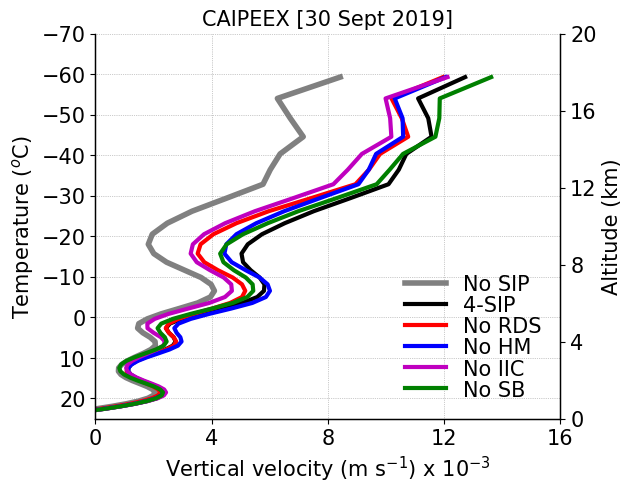

Time taken ::  34.382598876953125


In [11]:
import multiprocessing
import xarray as xr
import matplotlib.pyplot as plt
import time



start = time.time()

def process_dataset(args):
    """Parallel processing of each dataset"""
    ds, mean_tempc = args
    return ds.w_vel.mean(dim=('time', 'ncells')).where(mean_tempc > -60).compute().values

if __name__ == '__main__':
    mean_tempc = ds_4sip.tempc.mean(dim=('time', 'ncells')).compute()
    mean_ht = 1.e-3 * ds_4sip.z_mc.mean(dim=('time', 'ncells')).compute()

    datasets = [ds_nosip, ds_4sip, ds_norf, ds_nohm, ds_nobr, ds_nosb]

    # Parallel processing using multiprocessing
    with multiprocessing.Pool(processes=6) as pool:  # Use 6 workers
        results = pool.map(process_dataset, [(ds, mean_tempc) for ds in datasets])

    (mean_w_net_nosip, mean_w_net_4sip, mean_w_net_norf, mean_w_net_nohm, mean_w_net_nobr, mean_w_net_nosb) = results
    

    # Plotting 
    fontsize = 15
    lnwdth = 3
    alpha = 0.6

    plt.figure(figsize=(6, 5))
    plt1 = plt.gca()
    plt2 = plt1.twinx()
    plt1.plot(mean_w_net_nosip*1.e3, mean_tempc, '-', color='grey', linewidth=lnwdth+1, label='No SIP')
    plt1.plot(mean_w_net_4sip*1.e3, mean_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
    plt1.plot(mean_w_net_norf*1.e3, mean_tempc, 'r-', linewidth=lnwdth, label='No RDS')
    plt1.plot(mean_w_net_nohm*1.e3, mean_tempc, 'b-', linewidth=lnwdth, label='No HM')
    plt1.plot(mean_w_net_nobr*1.e3, mean_tempc, 'm-', linewidth=lnwdth, label='No IIC')
    plt1.plot(mean_w_net_nosb*1.e3, mean_tempc, 'g-', linewidth=lnwdth, label='No SB')

    plt2.plot(mean_w_net_nosip*1.e3, mean_ht, '-', color='none', linewidth=lnwdth+1)#, label='No SIP')

    plt1.set_xlim(0., 16)
    plt1.set_ylim(25, -70)
    plt2.set_ylim(0.5, 20)

    plt1.tick_params(axis='x', labelsize=fontsize)
    plt1.tick_params(axis='y', labelsize=fontsize)
    plt2.tick_params(axis='y', labelsize=fontsize) 
    
    
    plt1.set_xticks([0, 4, 8, 12, 16])
    plt1.set_yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70])
    plt2.set_yticks([0, 4, 8, 12, 16, 20])
    
    plt1.set_xlabel('Vertical velocity (m s$^{-1}$) x 10$^{-3}$', fontsize=fontsize)
    plt1.set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
    plt2.set_ylabel('Altitude (km)', fontsize=fontsize)
    plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
    plt1.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
    plt1.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
    plt1.spines['top'].set_visible(False)
    plt2.spines['top'].set_visible(False)
    #plt.spines['right'].set_visible(False)
    plt1.spines['left'].set_linewidth(1)
    plt1.spines['bottom'].set_linewidth(1)
    plt1.spines['right'].set_linewidth(1)
    plt.show()
    
    end = time.time()
    print('Time taken :: ', end-start)

In [66]:
print(ds_4sip.tempc[1,0,1].values)
print(ds_4sip.z_mc[1,0,1].values)

-67.23299
20700.926


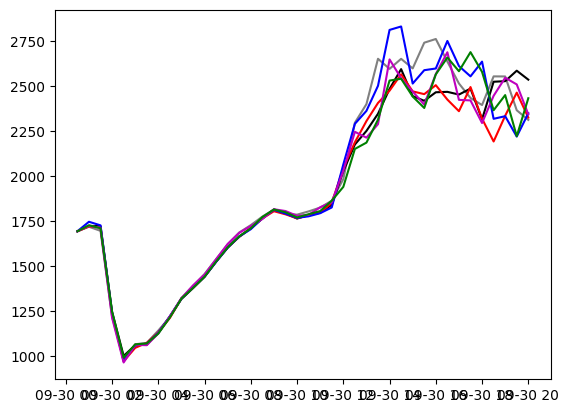

In [14]:


hbas_filt = xr.where(ds_nosip.hbas_con > 0., ds_nosip.hbas_con, np.nan)
htop_filt = xr.where(ds_nosip.htop_con > 0., ds_nosip.htop_con, np.nan)

cld_base_nosip = hbas_filt.mean('ncells')
cld_top_nosip = htop_filt.mean('ncells')

hbas_filt = xr.where(ds_4sip.hbas_con > 0., ds_4sip.hbas_con, np.nan)
htop_filt = xr.where(ds_4sip.htop_con > 0., ds_4sip.htop_con, np.nan)

cld_base_4sip = hbas_filt.mean('ncells')
cld_top_4sip = htop_filt.mean('ncells')

hbas_filt = xr.where(ds_norf.hbas_con > 0., ds_norf.hbas_con, np.nan)
htop_filt = xr.where(ds_norf.htop_con > 0., ds_norf.htop_con, np.nan)

cld_base_norf = hbas_filt.mean('ncells')
cld_top_norf = htop_filt.mean('ncells')

hbas_filt = xr.where(ds_nohm.hbas_con > 0., ds_nohm.hbas_con, np.nan)
htop_filt = xr.where(ds_nohm.htop_con > 0., ds_nohm.htop_con, np.nan)

cld_base_nohm = hbas_filt.mean('ncells')
cld_top_nohm = htop_filt.mean('ncells')


hbas_filt = xr.where(ds_nobr.hbas_con > 0., ds_nobr.hbas_con, np.nan)
htop_filt = xr.where(ds_nobr.htop_con > 0., ds_nobr.htop_con, np.nan)

cld_base_nobr = hbas_filt.mean('ncells')
cld_top_nobr = htop_filt.mean('ncells')


hbas_filt = xr.where(ds_nosb.hbas_con > 0., ds_nosb.hbas_con, np.nan)
htop_filt = xr.where(ds_nosb.htop_con > 0., ds_nosb.htop_con, np.nan)

cld_base_nosb = hbas_filt.mean('ncells')
cld_top_nosb = htop_filt.mean('ncells')



plt.plot(ds_nosip.time, cld_base_nosip, '-', color='grey')
plt.plot(ds_4sip.time, cld_base_4sip, 'k-')
plt.plot(ds_norf.time, cld_base_norf, 'r-')
plt.plot(ds_nohm.time, cld_base_nohm, 'b-')
plt.plot(ds_nobr.time, cld_base_nobr, 'm-')
plt.plot(ds_nosb.time, cld_base_nosb, 'g-')

In [7]:

mean_ht_nosip = ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# Latent heating rate with No SIP
filt_lhr = xr.where((ds_nosip.tq > 1.e-6) & (ds_nosip.w_vel > w_thres), ds_nosip.d_lhr, np.nan)
lhr_kpers_nosip = (1./1800.) * np.gradient(ds_nosip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosip = lhr_kpers_nosip * 86400.
mean_lhr_kperd_nosip = np.mean(lhr_kperd_nosip, axis=(0,2))

# Latent heating rate with 4-SIP
filt_lhr = xr.where((ds_4sip.tq > 1.e-6) & (ds_4sip.w_vel > w_thres), ds_4sip.d_lhr, np.nan)
lhr_kpers_4sip = (1./1800.) * np.gradient(ds_4sip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_4sip = lhr_kpers_4sip * 86400.
mean_lhr_kperd_4sip = np.mean(lhr_kperd_4sip, axis=(0,2))

# Latent heating rate with No Raindrop Shattering (RF)
filt_lhr = xr.where((ds_norf.tq > 1.e-6) & (ds_norf.w_vel > w_thres), ds_norf.d_lhr, np.nan)
lhr_kpers_norf = (1./1800.) * np.gradient(ds_norf.d_lhr, axis=0) # w.r.t. time
lhr_kperd_norf = lhr_kpers_norf * 86400.
mean_lhr_kperd_norf = np.mean(lhr_kperd_norf, axis=(0,2))

# Latent heating rate with No Hallett-Mossop (HM)
filt_lhr = xr.where((ds_nohm.tq > 1.e-6) & (ds_nohm.w_vel > w_thres), ds_nohm.d_lhr, np.nan)
lhr_kpers_nohm = (1./1800.) * np.gradient(ds_nohm.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nohm = lhr_kpers_nohm * 86400.
mean_lhr_kperd_nohm = np.mean(lhr_kperd_nohm, axis=(0,2))

# Latent heating rate with No ice-ice collision breakup (BR)
filt_lhr = xr.where((ds_nobr.tq > 1.e-6) & (ds_nobr.w_vel > w_thres), ds_nobr.d_lhr, np.nan)
lhr_kpers_nobr = (1./1800.) * np.gradient(ds_nobr.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nobr = lhr_kpers_nobr * 86400.
mean_lhr_kperd_nobr = np.mean(lhr_kperd_nobr, axis=(0,2))

# Latent heating rate with No Sublimation (SB)
filt_lhr = xr.where((ds_nosb.tq > 1.e-6) & (ds_nosb.w_vel > w_thres), ds_nosb.d_lhr, np.nan)
lhr_kpers_nosb = (1./1800.) * np.gradient(ds_nosb.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosb = lhr_kpers_nosb * 86400.
mean_lhr_kperd_nosb = np.mean(lhr_kperd_nosb, axis=(0,2))


# Change in lhr w.r.t. control
del_lhr_kperd_norf = mean_lhr_kperd_4sip-mean_lhr_kperd_norf
del_lhr_kperd_nohm = mean_lhr_kperd_4sip-mean_lhr_kperd_nohm
del_lhr_kperd_nobr = mean_lhr_kperd_4sip-mean_lhr_kperd_nobr
del_lhr_kperd_nosb = mean_lhr_kperd_4sip-mean_lhr_kperd_nosb
del_lhr_kperd_nosip = mean_lhr_kperd_4sip-mean_lhr_kperd_nosip


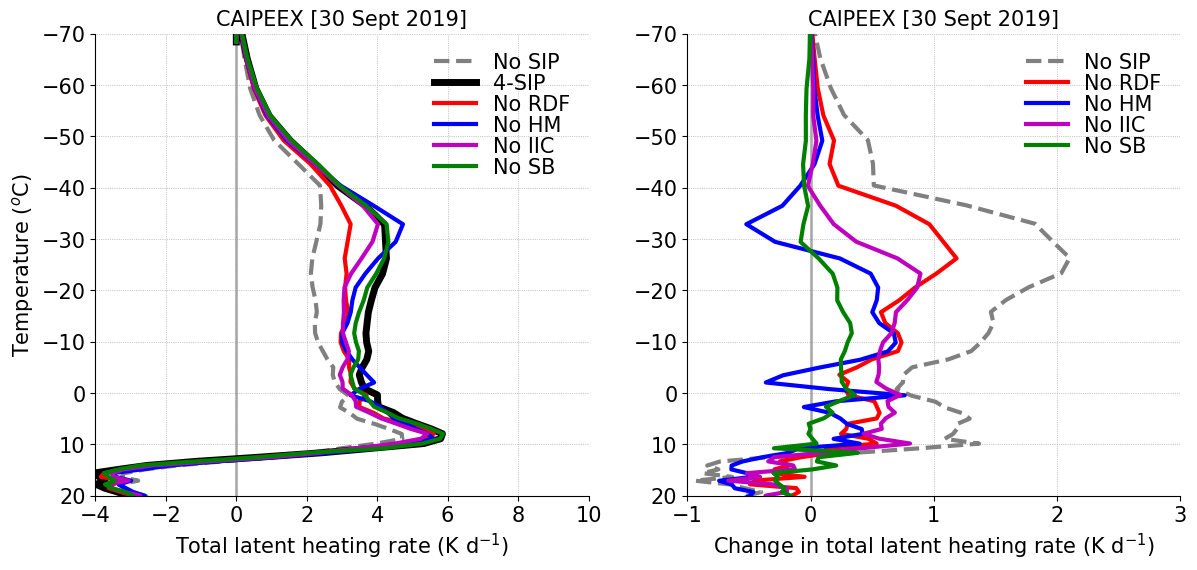

In [8]:

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-4, 10)
plt.ylim(20, -70)
plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-1, 3)
plt.ylim(20, -70)
plt.xticks([-1, 0, 1, 2, 3], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('CAIPEEX [30 Sept 2019]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


In [25]:

#######
min_tempc_sip = ds_4sip.tempc.min().values
max_tempc_sip = ds_4sip.tempc.max().values

min_wvel_sip = ds_4sip.w_vel.min().values
max_wvel_sip = ds_4sip.w_vel.max().values

num_temp_bin = 20; num_w_bin = 20;

temp_bin = np.linspace(min_tempc_sip, max_tempc_sip, num_temp_bin+1)
wvel_bin = np.linspace(min_wvel_sip, max_wvel_sip, num_w_bin+1)
#######

#######
tempc_sip_flat = ds_4sip.tempc.values.flatten()
wvel_sip_flat = ds_4sip.w_vel.values.flatten()

qc_sip_flat = ds_4sip.qc.values.flatten()
qi_sip_flat = ds_4sip.qi.values.flatten()
qs_sip_flat = ds_4sip.qs.values.flatten()
qg_sip_flat = ds_4sip.qg.values.flatten()
qh_sip_flat = ds_4sip.qh.values.flatten()
tqi_sip_flat = ds_4sip.tqi.values.flatten()
#######

hist_sip, temp_edges_sip, wvel_edges_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin))

#######
qc_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_sip_flat)[0]
qi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_sip_flat)[0]
qs_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qs_sip_flat)[0]
qg_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qg_sip_flat)[0]
qh_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qh_sip_flat)[0]
tqi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = tqi_sip_flat)[0]
#######

#######
avg_qc_temp_w_sip = qc_sum_sip/hist_sip
avg_qc_temp_w_sip[avg_qc_temp_w_sip < 1.e-9] = np.nan

avg_qi_temp_w_sip = qi_sum_sip/hist_sip
avg_qi_temp_w_sip[avg_qi_temp_w_sip < 1.e-9] = np.nan

avg_qs_temp_w_sip = qs_sum_sip/hist_sip
avg_qs_temp_w_sip[avg_qs_temp_w_sip < 1.e-9] = np.nan

avg_qg_temp_w_sip = qg_sum_sip/hist_sip
avg_qg_temp_w_sip[avg_qg_temp_w_sip < 1.e-9] = np.nan

avg_qh_temp_w_sip = qh_sum_sip/hist_sip
avg_qh_temp_w_sip[avg_qh_temp_w_sip < 1.e-9] = np.nan

avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip
avg_tqi_temp_w_sip[avg_tqi_temp_w_sip < 1.e-9] = np.nan
#######


/tmp/ipykernel_1917976/3900975349.py:8: RuntimeWarning: invalid value encountered in divide
  avg_qc_temp_w_sip = qc_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:11: RuntimeWarning: invalid value encountered in divide
  avg_qi_temp_w_sip = qi_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:14: RuntimeWarning: invalid value encountered in divide
  avg_qs_temp_w_sip = qs_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:17: RuntimeWarning: invalid value encountered in divide
  avg_qg_temp_w_sip = qg_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:20: RuntimeWarning: invalid value encountered in divide
  avg_qh_temp_w_sip = qh_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:23: RuntimeWarning: invalid value encountered in divide
  avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip


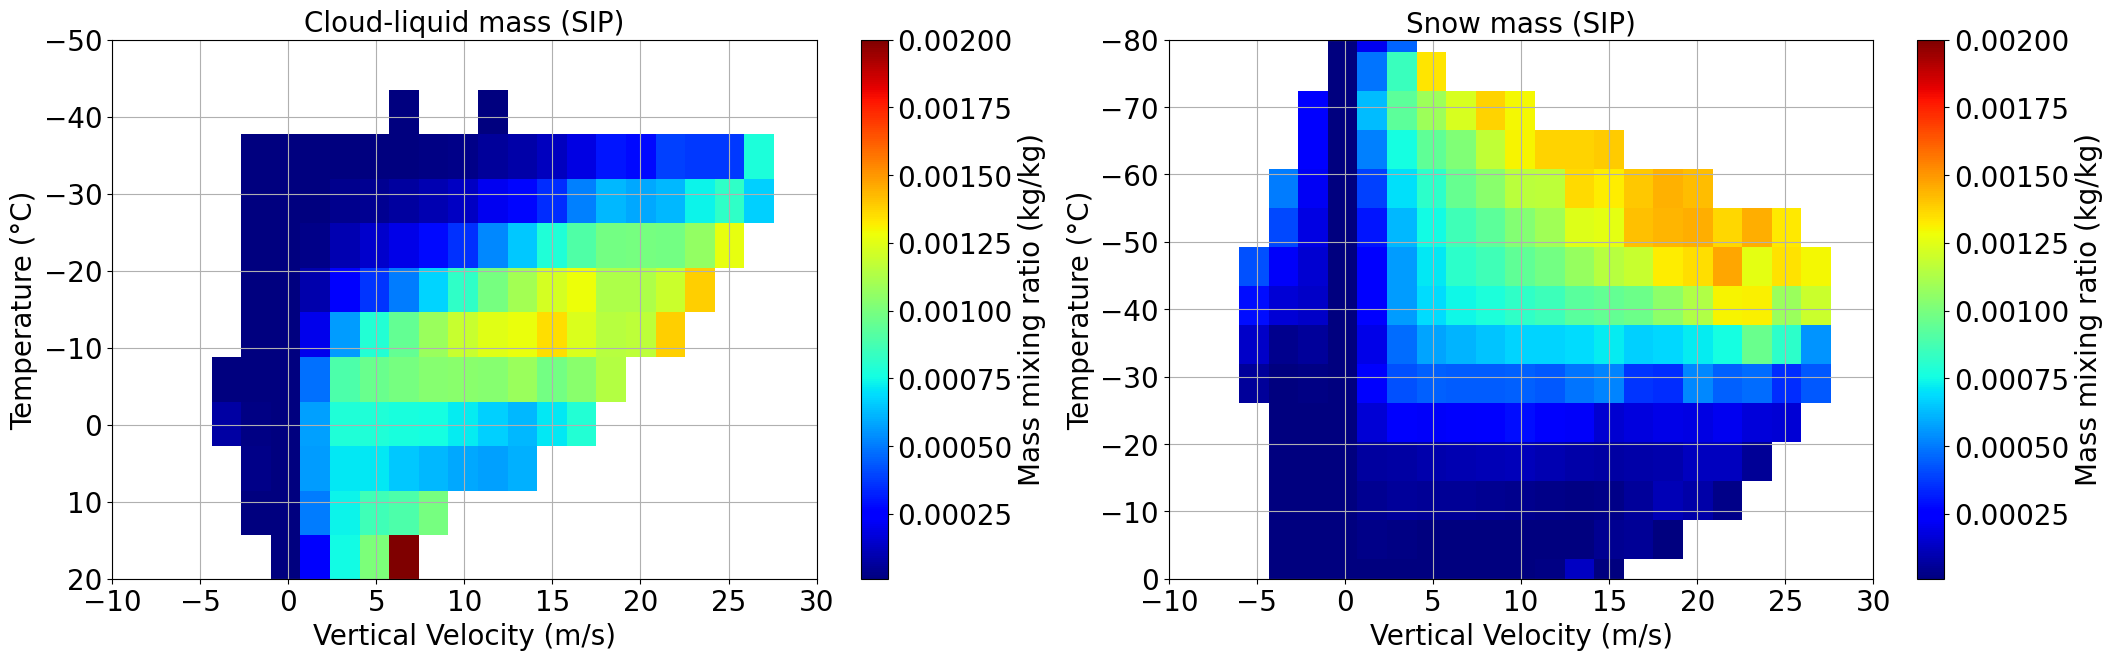

In [37]:

fontsize = 20;

plt.figure(figsize=(25, 7))
plt.subplot(1,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)
plt.show()

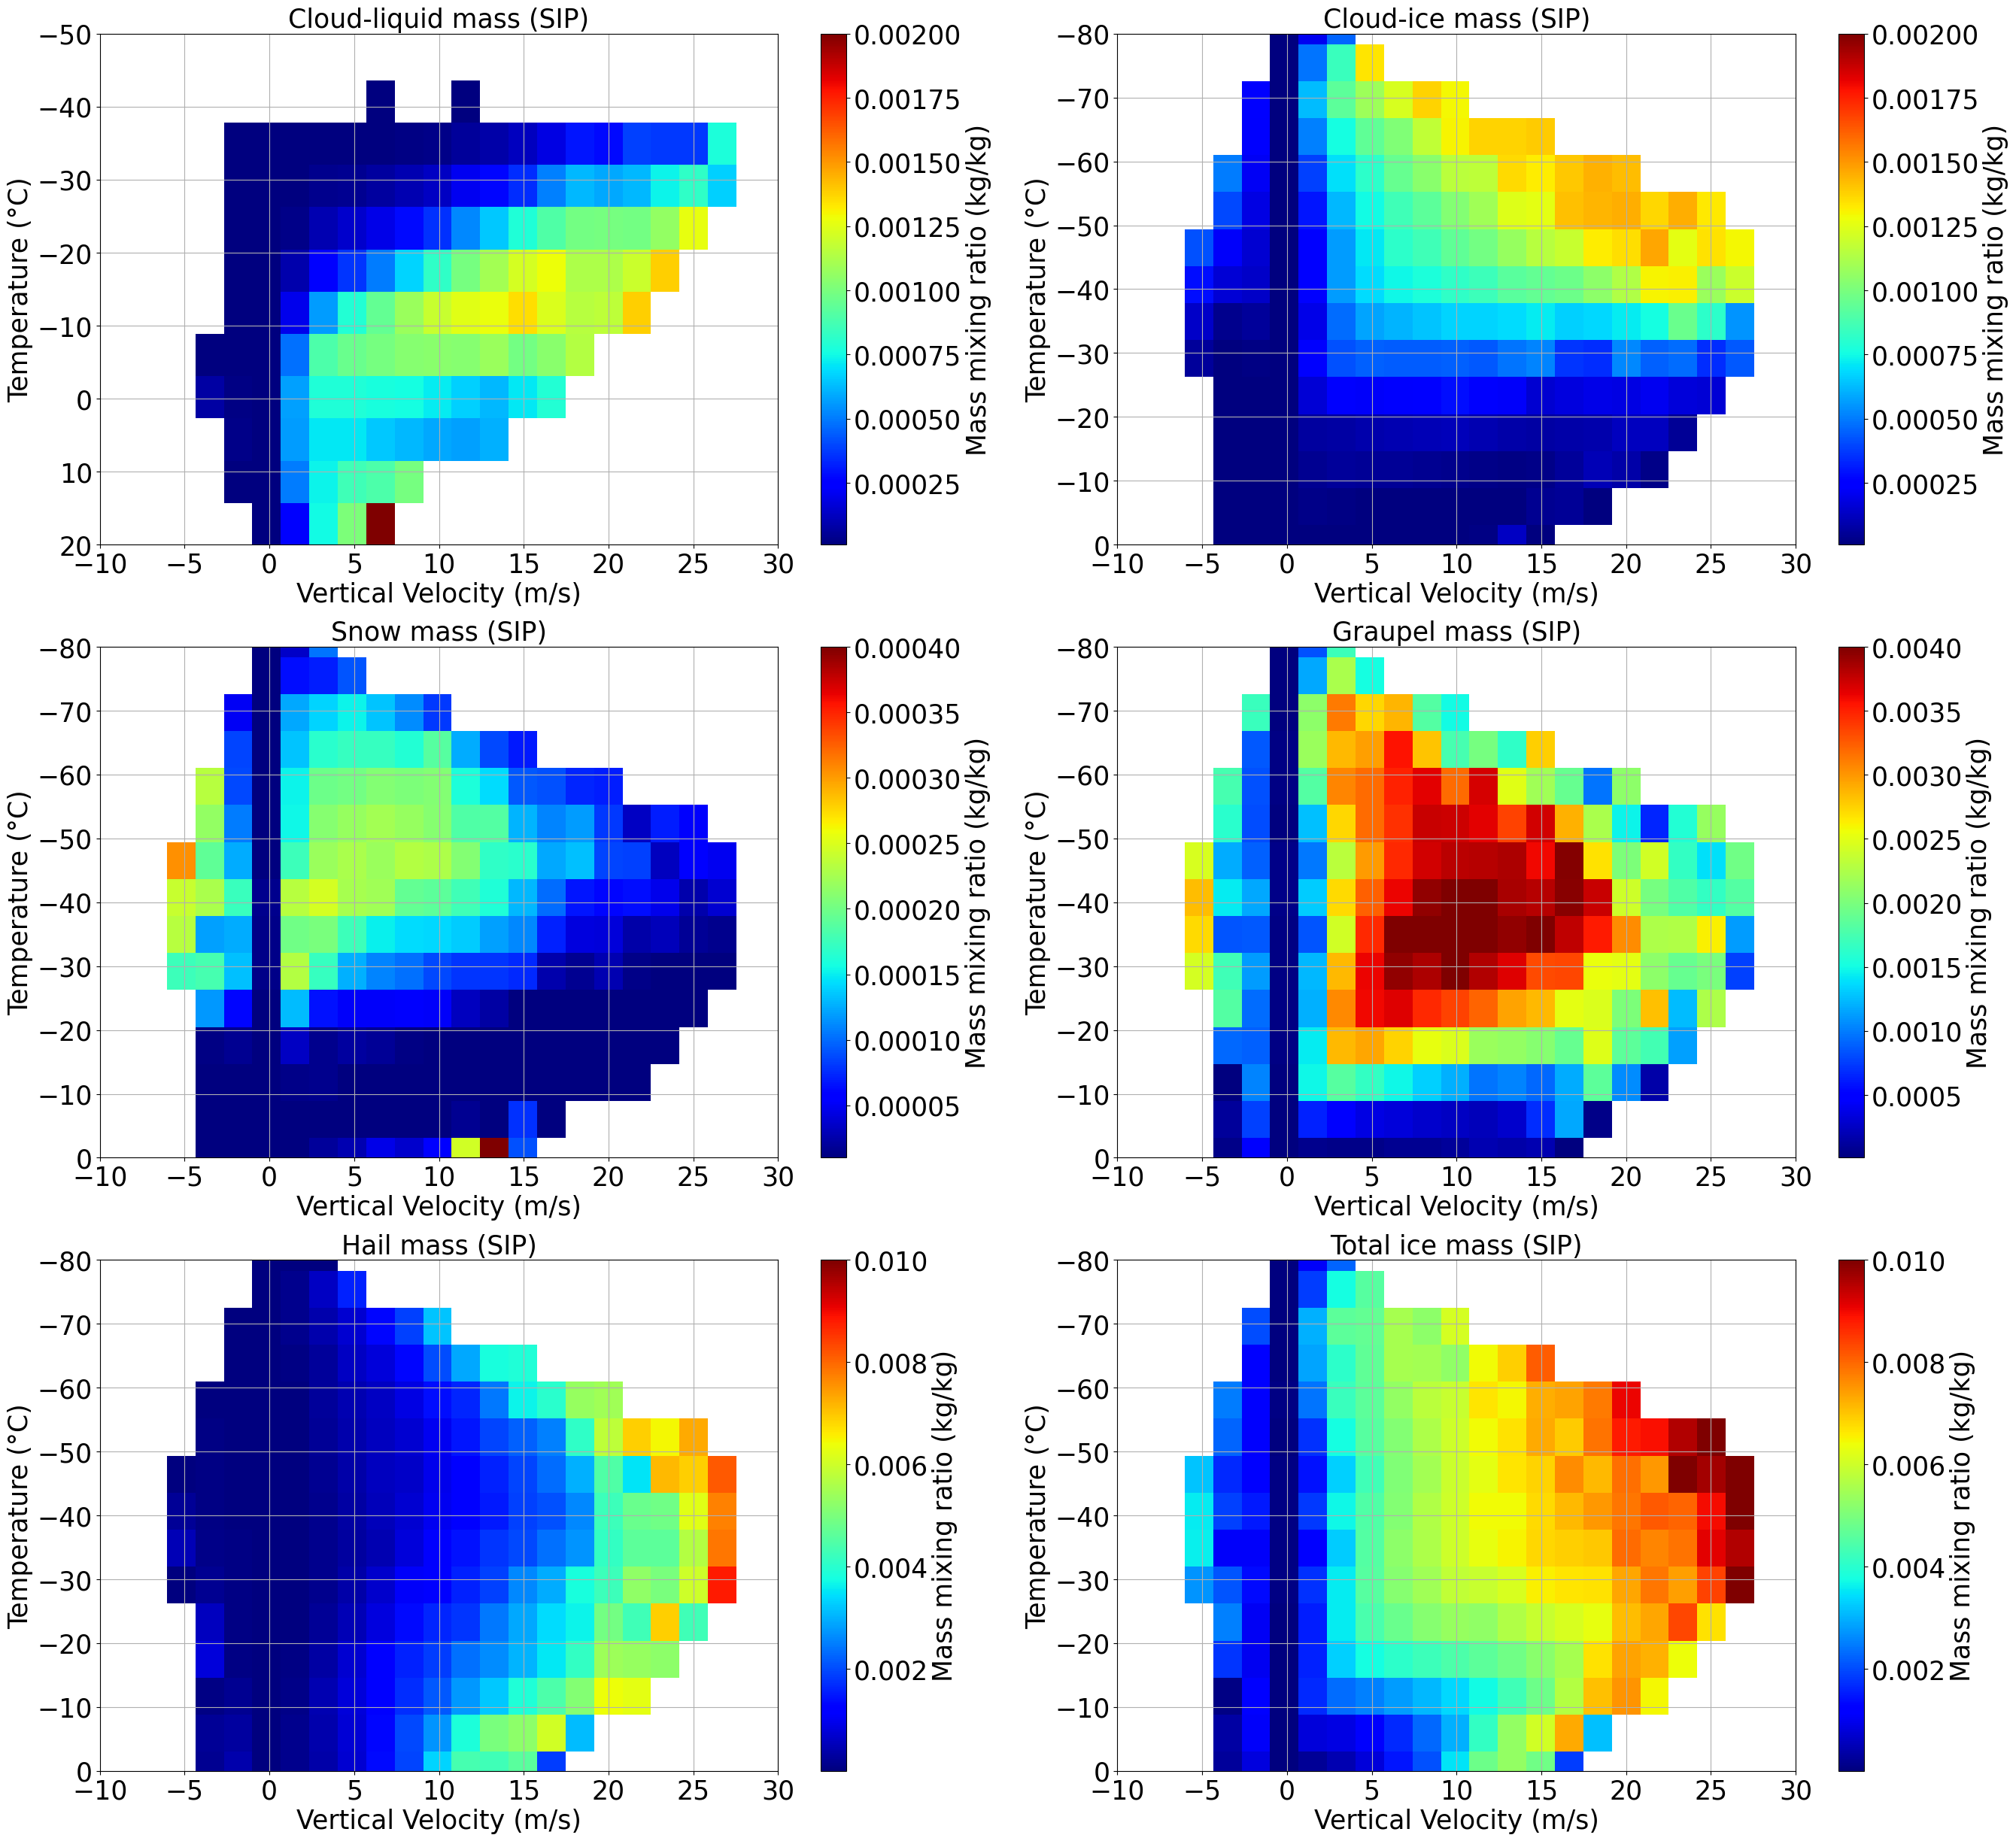

In [64]:


fontsize = 25;

plt.figure(figsize=(32, 30))
plt.subplot(3,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-ice mass (SIP)', fontsize=fontsize)
#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,3)
contour=plt.imshow(avg_qs_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-4, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,4)
contour=plt.imshow(avg_qg_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-3, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Graupel mass (SIP)', fontsize=fontsize)

#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,5)
contour=plt.imshow(avg_qh_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Hail mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,6)
contour=plt.imshow(avg_tqi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Total ice mass (SIP)', fontsize=fontsize)

plt.show()
